<a href="https://colab.research.google.com/github/TheLemonPig/RL-SSM/blob/main/RLWM_SSM_differentiable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install 'pymc>=5.9'
!pip install numpyro
!pip install git+https://github.com/AlexanderFengler/ssm-simulators@main
!pip install git+https://github.com/AlexanderFengler/LANfactory

In [1]:
import pymc as pm
import numpy as np
import random, pickle
import matplotlib.pyplot as plt
import pandas as pd
import pytensor
import pytensor.tensor as pt
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pickle
import ssms
from ssms.basic_simulators.simulator import simulator
import lanfactory

passing 1
wandb not available
wandb not available


We set the random seed at the start of the notebook and every time we want to regenerate the same dataset while debugging

In [2]:
np.random.seed(0)
random.seed(0)

##SSM for PyTensor Pre-Prep

Here we load in the LAN we need and save the weights and biases as numpy arrays

In [3]:
ssms_model = 'lba_angle_3_v1'
model_config = ssms.config.model_config[ssms_model]
param_theta = np.array([0.5, 0.3, 0.2, 0.5, 0.2, 0.0])
res = simulator(
                param_theta,
                model=ssms_model,
                n_samples=2000,
                delta_t=0.001,
                max_t=5,
                )
network_config = pickle.load(open('/content/drive/MyDrive/hssm_rlwm/LANs/lba_angle_3_v1_torch__network_config.pickle', 'rb'))
model_file_path = '/content/drive/MyDrive/hssm_rlwm/LANs/lba_angle_3_v1_torch_state_dict.pt'
torch_mlp = lanfactory.trainers.torch_mlp.LoadTorchMLPInfer(model_file_path = model_file_path,
                                                network_config = network_config,
                                                input_dim = 6 + 2) ## 6 is a hard-coded value for lba_angle_3_v1

Setting network type to "lan" or "cpn" based on train_output_type. 
Note: This is only a default setting, and can be overwritten by the network_type argument.
tanh
tanh
tanh
linear


In [4]:
weights_0 = torch_mlp.net.state_dict()['layers.0.weight'].cpu().numpy().astype(np.float32).T
weights_1 = torch_mlp.net.state_dict()['layers.2.weight'].cpu().numpy().astype(np.float32).T
weights_2 = torch_mlp.net.state_dict()['layers.4.weight'].cpu().numpy().astype(np.float32).T
weights_3 = torch_mlp.net.state_dict()['layers.6.weight'].cpu().numpy().astype(np.float32).T
biases_0 = torch_mlp.net.state_dict()['layers.0.bias'].cpu().numpy().astype(np.float32).T
biases_1 = torch_mlp.net.state_dict()['layers.2.bias'].cpu().numpy().astype(np.float32).T
biases_2 = torch_mlp.net.state_dict()['layers.4.bias'].cpu().numpy().astype(np.float32).T
biases_3 = torch_mlp.net.state_dict()['layers.6.bias'].cpu().numpy().astype(np.float32).T

##PyTensor

####Functions

In [6]:
def rlwm_step(dC, dR, pA, pG, pP, dq_RL, dq_WM):
    """
    rlwm_step: calculate a single RLWM step

    (n_participants, n_choices, n_blocks, n_stimuli)
    dC: Choices (data)
    dR: Rewards (data)
    pA: Alphas (parameter)
    pG: Gammas (parameter)
    pP: Phis (parameter)
    dq_RL: RL Qs (data)
    dq_WM: WM Qs (data)
    """
    cond = pt.switch(pt.lt(dq_RL, dR), 1, 0)
    dq_RL += (cond + (1.0 - cond) * pG) * pA * (dR - dq_RL) * dC
    dq_WM += (cond + (1.0 - cond) * pG) * 1.0 * (dR - dq_WM) * dC
    dq_WM += pP * (1 / dR.shape[1] - dq_WM)
    return [dq_RL, dq_WM]

def rlwm_scan(dC, dR, pA, pG, pP, dq_RL, dq_WM):
    """
    rlwm_scan: calculate a RLWM Q-Values

    (n_trials, n_participants, n_choices, n_blocks, n_stimuli)
    dC: Choices (data)
    dR: Rewards (data)
    pA: Alphas (parameter)
    pG: Gammas (parameter)
    pP: Phis (parameter)
    dq_RL: RL Qs (data)
    dq_WM: WM Qs (data)
    """
    ([dQ_RL, dQ_WM], _) = pytensor.scan(rlwm_step, sequences=[dC, dR, pA, pG, pP], non_sequences=[], outputs_info=[dq_RL, dq_WM])
    shape = dC.shape
    n_trials_m1 = shape[0]-1
    dQ_RL = pt.subtensor.set_subtensor(pt.repeat(dq_RL.reshape((1,shape[1],shape[2],shape[3],shape[4])),shape[0],axis=0)[-n_trials_m1:], dQ_RL[:n_trials_m1])
    dQ_WM = pt.subtensor.set_subtensor(pt.repeat(dq_WM.reshape((1,shape[1],shape[2],shape[3],shape[4])),shape[0],axis=0)[-n_trials_m1:], dQ_WM[:n_trials_m1])
    return dQ_RL, dQ_WM


def pytensor_softmax(Qs, pB):
    """
    rlwm_softmax: calculate probabilities using a tempered softmax over Q-Values

    Qs: Q-Values (data)
    pB: Betas (parameter)
    """
    shape = Qs.shape
    tempered_qs = pt.mul(Qs,pB)
    qs_max = pt.max(tempered_qs,axis=2)
    qs_max = pt.repeat(qs_max.reshape((shape[0], shape[1], 1, shape[3], shape[4])), shape[2], axis=2)
    numerator = pt.exp(tempered_qs - qs_max)
    denominator = pt.sum(numerator, axis=2)
    denominator = pt.repeat(denominator.reshape((shape[0], shape[1], 1, shape[3], shape[4])), shape[2], axis=2)
    Ps = numerator / denominator
    return Ps

def rlwm_policy(dC, dq_RL, dq_WM, pB, pC, pE, pR, set_sizes):
    """
    rlwm_policy: compute RLWM Q-Learning policy

    dC: Choices (data)
    dq_RL: Precomputed RL Qs (data)
    dq_WM: Precomputed WM Qs (data)
    pB: Betas (parameter)
    pC: Working Memory Capacities (parameter)
    pE: Epsilons (parameter)
    pR: Rhos (parameter)
    set_sizes: set sizes for each participant block (data)
    """
    weight = pR * pt.clip(pC/set_sizes, 0, 1)
    Ps_RL = pytensor_softmax(dq_RL, pB)
    Ps_WM = pytensor_softmax(dq_WM, pB)
    pol = weight * Ps_WM + (1.0 - weight) * Ps_RL
    pol_final = (1.0 - pE) * pol + pE * 1.0/dC.shape[2]
    return pol_final

def scan_to_lan(dC, pol_final):
    """
    scan_to_lan: reshape RLWM policy and onehot-padded choices into Vs to pass through the LAN

    dC: one-hotted padded Choices (data)
    pol_final: RLWM policy (computed)
    """
    trial_dim = 0
    participant_dim = 1
    choice_dim = 2
    block_dim = 3
    state_dim = 4
    # pol_final: (n_trials, n_participants, n_choices, n_blocks, n_stimuli)
    pol_final_reshaped = pol_final.dimshuffle((participant_dim, block_dim, trial_dim, state_dim, choice_dim)).reshape((-1, dC.shape[state_dim], dC.shape[choice_dim]))
    dC_reshaped = dC.dimshuffle((participant_dim, block_dim, trial_dim, state_dim, choice_dim)).reshape((-1,dC.shape[state_dim],dC.shape[choice_dim]))
    dC_padding = pt.sum(dC_reshaped,axis=2)
    pssmV = pol_final_reshaped * pt.repeat(dC_padding.reshape((-1,dC.shape[4],1)),dC.shape[2],axis=2)
    return pssmV.max(axis=1)

def pytensor_lan(weights_0,weights_1,weights_2,weights_3,biases_0,biases_1,biases_2,biases_3,in_):
    """
    pytensor_lan: compute LAN likelihood using weights from torch model initialized in pytensor

    weights_0: first layer weights (data)
    weights_1: second layer weights (data)
    weights_2: third layer weights (data)
    weights_3: fourth layer weights (data)
    biases_0: first layer biases (data)
    biases_1: second layer biases (data)
    biases_2: third layer biases (data)
    biases_3: fourth layer biases (data)
    in_: inputs variables to pass through [v_0, v_1, v_2, rl_a, rl_z, rl_theta, RTs, Choices] (parameter / data)
    """
    hid0 = pt.tanh(pt.dot(in_,weights_0)+biases_0)
    hid1 = pt.tanh(pt.dot(hid0, weights_1)+biases_1)
    hid2 = pt.tanh(pt.dot(hid1, weights_2)+biases_2)
    out = pt.dot(hid2, weights_3)+biases_3
    return out

def rlwmssm_likelihood(dC, dq_RL, dq_WM, pB, pC, pE, pR, set_sizes, pssmA, pssmZ, pssmT, dssmRT, dssmC, weights_0,weights_1,weights_2,weights_3,biases_0,biases_1,biases_2,biases_3):
    """
    rlwm_likelihood: calculate RLWM-SSM Likelihoods from precomputed Q-Values

    dC: Choices (data)
    dq_RL: Precomputed RL Qs (computed)
    dq_WM: Precomputed WM Qs (computed)
    pB: Betas (parameter)
    pC: Working Memory Capacities (parameter)
    pE: Epsilons (parameter)
    pR: Rhos (parameter)
    set_sizes: set sizes for each participant block (data)
    pssmA: SSM As (parameter)
    pssmZ: SSM Zs (parameter)
    pssmT: SSM Thetas (parameter)
    dssmRT: SSM RTs (data)
    dssmC: unpadded Choices from SSM (data)
    weights_0: first layer weights (data)
    weights_1: second layer weights (data)
    weights_2: third layer weights (data)
    weights_3: fourth layer weights (data)
    biases_0: first layer biases (data)
    biases_1: second layer biases (data)
    biases_2: third layer biases (data)
    biases_3: fourth layer biases (data)
    """
    trial_dim = 0
    participant_dim = 1
    choice_dim = 2
    block_dim = 3
    state_dim = 4
    # pol_final: (n_trials, n_participants, n_choices, n_blocks, n_stimuli)
    pol_final = rlwm_policy(dC, dq_RL, dq_WM, pB, pC, pE, pR, set_sizes)
    pssmV = scan_to_lan(dC, pol_final)
    # What do I do with choices and rts? How do I put them through the LAN with the parameters?
    in_ = pt.concatenate([pssmV, pssmA.reshape((-1,1)), pssmZ.reshape((-1,1)), pssmT.reshape((-1,1)), dssmRT.reshape((-1,1)), dssmC.reshape((-1,1))], axis=1)
    ll = pytensor_lan(weights_0,weights_1,weights_2,weights_3,biases_0,biases_1,biases_2,biases_3,in_)
    dC_reshaped = dC.dimshuffle((participant_dim, block_dim, trial_dim, state_dim, choice_dim)).reshape((-1,dC.shape[state_dim],dC.shape[choice_dim]))
    dC_padding = dC_reshaped.sum(axis=[1,2]).reshape((-1,1))
    ll_unpadded = ll * dC_padding
    return ll_unpadded
    # return ll


def rlwmssm_recovery(dq_RL, dq_WM, dC, dR, pA, pB, pC, pE, pG, pP, pR, set_sizes, pssmA, pssmZ, pssmT, dssmRT, dssmC, weights_0,weights_1,weights_2,weights_3,biases_0,biases_1,biases_2,biases_3):
    """
    rlwm_likelihood: calculate RLWM-SSM Likelihoods using a LAN fitted to the LBA SSM

    dC: Choices (data)
    dq_RL: Precomputed RL Qs (empty)
    dq_WM: Precomputed WM Qs (empty)
    pB: Betas (parameter)
    pC: Working Memory Capacities (parameter)
    pE: Epsilons (parameter)
    pR: Rhos (parameter)
    set_sizes: set sizes for each participant block (data)
    pssmA: SSM As (parameter)
    pssmZ: SSM Zs (parameter)
    pssmT: SSM Thetas (parameter)
    dssmRT: SSM RTs (data)
    dssmC: unpadded Choices from SSM (data)
    weights_0: first layer weights (data)
    weights_1: second layer weights (data)
    weights_2: third layer weights (data)
    weights_3: fourth layer weights (data)
    biases_0: first layer biases (data)
    biases_1: second layer biases (data)
    biases_2: third layer biases (data)
    biases_3: fourth layer biases (data)
    """
    dq_RL, dq_WM = rlwm_scan(dC, dR, pA, pG, pP, dq_RL, dq_WM)
    likelihood = rlwmssm_likelihood(dC, dq_RL, dq_WM, pB, pC, pE, pR, set_sizes, pssmA, pssmZ, pssmT, dssmRT, dssmC, weights_0,weights_1,weights_2,weights_3,biases_0,biases_1,biases_2,biases_3)
    return likelihood

####Compilers

In [7]:
def rlwm_step_compile():
    """
    rlwm_step_compile: compiler for rlwm_step function

    (n_participants, n_choices, n_blocks, n_stimuli)
    dC: Choices (data)
    dR: Rewards (data)
    pA: Alphas (parameter)
    pG: Gammas (parameter)
    pP: Phis (parameter)
    dq_RL: RL Qs (data)
    dq_WM: WM Qs (data)
    """
    dC4 = pt.dtensor4("dC4")
    dR4 = pt.dtensor4("dR4")
    dq_RL4 = pt.dtensor4("dq_RL4")
    dq_WM4 = pt.dtensor4("dq_WM4")
    pA4 = pt.dtensor4("pA4")
    pG4 = pt.dtensor4("pG4")
    pP4 = pt.dtensor4("pP4")

    dq_RL, dq_WM = rlwm_step(dC4, dR4, pA4, pG4, pP4, dq_RL4, dq_WM4)
    rlwm_step_func = pytensor.function(inputs=[dC4, dR4, pA4, pG4, pP4, dq_RL4, dq_WM4], outputs=[dq_RL, dq_WM])

    return rlwm_step_func


def rlwm_scan_compile():
    """
    rlwm_scan_compile: compiler for rlwm_scan function

    (n_trials, n_participants, n_choices, n_blocks, n_stimuli)
    dC: Choices (data)
    dR: Rewards (data)
    pA: Alphas (parameter)
    pG: Gammas (parameter)
    pP: Phis (parameter)
    dq_RL: RL Qs (data)
    dq_WM: WM Qs (data)
    """
    dC5 = pt.dtensor5("dC5")
    dR5 = pt.dtensor5("dR5")
    dq_RL4 = pt.dtensor4("dq_RL4")
    dq_WM4 = pt.dtensor4("dq_WM4")
    pA5 = pt.dtensor5("pA5")
    pG5 = pt.dtensor5("pG5")
    pP5 = pt.dtensor5("pP5")

    dq_RL, dq_WM = rlwm_scan(dC5, dR5, pA5, pG5, pP5, dq_RL4, dq_WM4)
    rlwm_step_func = pytensor.function(inputs=[dC5, dR5, pA5, pG5, pP5, dq_RL4, dq_WM4], outputs=[dq_RL, dq_WM])

    return rlwm_step_func


def pytensor_softmax_compile():
    """
    rlwm_softmax_compile: compiler for pytensor_softmax function

    (n_trials, n_participants, n_choices, n_blocks, n_stimuli)
    Qs: Q-Values (data)
    pB: Betas (parameter)
    """
    Qs = pt.dtensor5('Qs')
    B = pt.dtensor5('B')

    Ps = pytensor_softmax(Qs, B)
    Ps_func = pytensor.function(inputs=[Qs, B], outputs=Ps)

    return Ps_func

def scan_to_lan_compile():
    """
    scan_to_lan_compile: compiler for scan_to_lan function

    (n_trials, n_participants, n_choices, n_blocks, n_stimuli)
    dC: one-hotted padded Choices (data)
    pol_final: RLWM policy (computed)
    """
    dC = pt.dtensor5("dC_")
    pol_final = pt.dtensor5("pol_final")

    out = scan_to_lan(dC, pol_final)

    pytensor_lan_func = pytensor.function(inputs=[dC, pol_final],outputs=out, on_unused_input='ignore')
    return pytensor_lan_func


def pytensor_lan_compile():
    """
    pytensor_lan_compile: compiler for pytensor_lan function

    (n_participants * n_blocks * n_trials, 8)
    weights_0: first layer weights (data)
    weights_1: second layer weights (data)
    weights_2: third layer weights (data)
    weights_3: fourth layer weights (data)
    biases_0: first layer biases (data)
    biases_1: second layer biases (data)
    biases_2: third layer biases (data)
    biases_3: fourth layer biases (data)
    in_: inputs variables to pass through [v_0, v_1, v_2, pssmA, pssmZ, pssmT, dssmRT, dssmC] (parameter / data)
    v_0: Vs corresponding to Q-values for the first possible action
    v_1: Vs corresponding to Q-values for the second possible action
    v_2: Vs corresponding to Q-values for the third possible action
    pssmA: SSM As (parameter)
    pssmZ: SSM Zs (parameter)
    pssmT: SSM Thetas (parameter)
    dssmRT: SSM RTs (data)
    dssmC: unpadded Choices from SSM (data)
    """
    weights_0 = pt.dmatrix("weights_0")
    weights_1 = pt.dmatrix("weights_1")
    weights_2 = pt.dmatrix("weights_2")
    weights_3 = pt.dmatrix("weights_3")
    biases_0 = pt.dvector("biases_0")
    biases_1 = pt.dvector("biases_1")
    biases_2 = pt.dvector("biases_2")
    biases_3 = pt.dvector("biases_3")
    in_ = pt.dmatrix('in_')

    ll = pytensor_lan(weights_0,weights_1,weights_2,weights_3,biases_0,biases_1,biases_2,biases_3,in_)
    pytensor_lan_func = pytensor.function(inputs=[weights_0,weights_1,weights_2,weights_3,biases_0,biases_1,biases_2,biases_3, in_],outputs=ll)
    return pytensor_lan_func


def rlwmssm_likelihood_compile():
    """
    rlwm_likelihood_compile: compiler for rlwm_likelihood function

    (n_trials, n_participants, n_choices, n_blocks, n_stimuli)
    dC: Choices (data)
    dq_RL: Precomputed RL Qs (computed)
    dq_WM: Precomputed WM Qs (computed)
    pB: Betas (parameter)
    pC: Working Memory Capacities (parameter)
    pE: Epsilons (parameter)
    pR: Rhos (parameter)
    set_sizes: set sizes for each participant block (data)
    pssmA: SSM As (parameter)
    pssmZ: SSM Zs (parameter)
    pssmT: SSM Thetas (parameter)
    dssmRT: SSM RTs (data)
    dssmC: unpadded Choices from SSM (data)
    weights_0: first layer weights (data)
    weights_1: second layer weights (data)
    weights_2: third layer weights (data)
    weights_3: fourth layer weights (data)
    biases_0: first layer biases (data)
    biases_1: second layer biases (data)
    biases_2: third layer biases (data)
    biases_3: fourth layer biases (data)
    """
    dC = pt.dtensor5("dC")
    dq_RL = pt.dtensor5("dq_RL")
    dq_WM = pt.dtensor5("dq_WM")
    pB = pt.dtensor5("pB")
    pC = pt.dtensor5("pC")
    pE = pt.dtensor5("pE")
    pR = pt.dtensor5("pR")
    set_sizes = pt.dtensor5("set_sizes")
    pssmA = pt.dvector("pssmA")
    pssmZ = pt.dvector("pssmZ")
    pssmT = pt.dvector("pssmT")
    dssmC = pt.dvector("dssmC")
    dssmRT = pt.dvector("dssmRT")
    weights_0 = pt.dmatrix("weights_0")
    weights_1 = pt.dmatrix("weights_1")
    weights_2 = pt.dmatrix("weights_2")
    weights_3 = pt.dmatrix("weights_3")
    biases_0 = pt.dvector("biases_0")
    biases_1 = pt.dvector("biases_1")
    biases_2 = pt.dvector("biases_2")
    biases_3 = pt.dvector("biases_3")
    likelihood = rlwmssm_likelihood(dC, dq_RL, dq_WM, pB, pC, pE, pR, set_sizes, pssmA, pssmZ, pssmT, dssmC, dssmRT, weights_0,weights_1,weights_2,weights_3,biases_0,biases_1,biases_2,biases_3)
    rlwm_likelihood_func = pytensor.function(inputs=[dC, dq_RL, dq_WM, pB, pC, pE, pR, set_sizes, pssmA, pssmZ, pssmT, dssmC, dssmRT, weights_0,weights_1,weights_2,weights_3,biases_0,biases_1,biases_2,biases_3], outputs=likelihood)

    return rlwm_likelihood_func

def rlwmssm_recovery_compile():
    """
    rlwm_recovery_compile: compiler for rlwmssm_recovery function

    (n_trials, n_participants, n_choices, n_blocks, n_stimuli)
    dC: Choices (data)
    dq_RL: Precomputed RL Qs (empty)
    dq_WM: Precomputed WM Qs (empty)
    pB: Betas (parameter)
    pC: Working Memory Capacities (parameter)
    pE: Epsilons (parameter)
    pR: Rhos (parameter)
    set_sizes: set sizes for each participant block (data)
    pssmA: SSM As (parameter)
    pssmZ: SSM Zs (parameter)
    pssmT: SSM Thetas (parameter)
    dssmRT: SSM RTs (data)
    dssmC: unpadded Choices from SSM (data)
    weights_0: first layer weights (data)
    weights_1: second layer weights (data)
    weights_2: third layer weights (data)
    weights_3: fourth layer weights (data)
    biases_0: first layer biases (data)
    biases_1: second layer biases (data)
    biases_2: third layer biases (data)
    biases_3: fourth layer biases (data)
    """
    dq_RL = pt.dtensor4("dq_RL")
    dq_WM = pt.dtensor4("dq_WM")
    dC = pt.dtensor5("dC")
    dR = pt.dtensor5("dR")
    pA = pt.dtensor5("pA")
    pB = pt.dtensor5("pB")
    pC = pt.dtensor5("pC")
    pE = pt.dtensor5("pE")
    pG = pt.dtensor5("pG")
    pP = pt.dtensor5("pP")
    pR = pt.dtensor5("pR")
    set_sizes = pt.dtensor5("set_sizes")
    pssmA = pt.dvector("pssmA")
    pssmZ = pt.dvector("pssmZ")
    pssmT = pt.dvector("pssmT")
    dssmC = pt.dvector("dssmC")
    dssmRT = pt.dvector("dssmRT")
    weights_0 = pt.dmatrix("weights_0")
    weights_1 = pt.dmatrix("weights_1")
    weights_2 = pt.dmatrix("weights_2")
    weights_3 = pt.dmatrix("weights_3")
    biases_0 = pt.dvector("biases_0")
    biases_1 = pt.dvector("biases_1")
    biases_2 = pt.dvector("biases_2")
    biases_3 = pt.dvector("biases_3")

    likelihood = rlwmssm_recovery(dq_RL, dq_WM, dC, dR, pA, pB, pC, pE, pG, pP, pR, set_sizes, pssmA, pssmZ, pssmT, dssmC, dssmRT, weights_0,weights_1,weights_2,weights_3,biases_0,biases_1,biases_2,biases_3)
    rlwm_recovery_func = pytensor.function(inputs=[dq_RL, dq_WM, dC, dR, pA, pB, pC, pE, pG, pP, pR, set_sizes, pssmA, pssmZ, pssmT, dssmC, dssmRT, weights_0,weights_1,weights_2,weights_3,biases_0,biases_1,biases_2,biases_3], outputs=likelihood,
                                           on_unused_input='ignore')

    return rlwm_recovery_func

###Tests

In [8]:
def rlwm_step_test():
    """
    rlwm_step_test: test for rlwm_step function

    (n_participants, n_choices, n_blocks, n_stimuli)
    dC: Choices (data)
    dR: Rewards (data)
    pA: Alphas (parameter)
    pG: Gammas (parameter)
    pP: Phis (parameter)
    dq_RL: RL Qs (data)
    dq_WM: WM Qs (data)
    """
    n_participants = 6
    n_choices = 3
    n_stimuli = [4, 5, 6, 7, 8]
    max_stimuli = max(n_stimuli)
    n_blocks = 5
    shape = (n_participants, n_choices, n_blocks, max_stimuli)

    dC_ = np.random.randint(low=0, high=n_choices, size=shape)
    dR_ = np.random.randint(low=0, high=1, size=shape)
    pA_ = np.ones(shape) * 0.1
    pG_ = np.ones(shape) * 0.9
    pP_ = np.ones(shape) * 1.0
    dQ_ = np.ones(shape) * 1/n_choices
    dq_RL_ = np.ones(shape) * 1/n_choices
    dq_WM_ = np.ones(shape) * 1/n_choices

    test_func = rlwm_step_compile()

    return test_func(dC_, dR_, pA_, pG_, pP_, dq_RL_, dq_WM_)


def rlwm_scan_test():
    """
    rlwm_scan_test: test for rlwm_scan function

    (n_trials, n_participants, n_choices, n_blocks, n_stimuli)
    dC: Choices (data)
    dR: Rewards (data)
    pA: Alphas (parameter)
    pG: Gammas (parameter)
    pP: Phis (parameter)
    dq_RL: RL Qs (data)
    dq_WM: WM Qs (data)
    """
    n_trials = 23
    n_participants = 6
    n_choices = 3
    n_stimuli = [4, 5, 6, 7, 8]
    max_stimuli = max(n_stimuli)
    n_blocks = 5
    shape5 = (n_trials * max_stimuli, n_participants, n_choices, n_blocks, max_stimuli)

    dC_ = np.random.randint(low=0, high=n_choices, size=shape5)
    dR_ = np.random.randint(low=0, high=1, size=shape5)
    dq_RL_ = np.ones_like(dR_)[0] * 1 / n_choices
    dq_WM_ = np.ones_like(dR_)[0] * 1 / n_choices
    pA_ = np.ones_like(dR_) * 0.1
    pG_ = np.ones_like(dR_) * 0.9
    pP_ = np.ones_like(dR_) * 1.0

    test_func = rlwm_scan_compile()

    return test_func(dC_, dR_, pA_, pG_, pP_, dq_RL_, dq_WM_)


def pytensor_softmax_test():
    """
    rlwm_softmax_test: test for pytensor_softmax function

    (n_trials, n_participants, n_choices, n_blocks, n_stimuli)
    Qs: Q-Values (data)
    pB: Betas (parameter)
    """
    n_trials = 23
    n_participants = 6
    n_choices = 3
    n_stimuli = [4, 5, 6, 7, 8]
    max_stimuli = np.max(n_stimuli)
    n_blocks = 5
    shape = (n_trials * max_stimuli, n_participants, n_choices, n_blocks, max_stimuli)

    Qs = np.ones(shape)
    B = np.ones_like(Qs)

    test_func = pytensor_softmax_compile()

    return test_func(Qs, B)

def scan_to_lan_test():
    """
    scan_to_lan_test: test for scan_to_lan function

    (n_trials, n_participants, n_choices, n_blocks, n_stimuli)
    dC: one-hotted padded Choices (data)
    pol_final: RLWM policy (computed)
    """
    n_trials = 23
    n_participants = 7
    n_choices = 3
    n_stimuli = [2,2,3,4,4,5]
    max_stimuli = np.max(n_stimuli)
    n_blocks = 6
    shape = (n_trials * max_stimuli, n_participants, n_choices, n_blocks, max_stimuli)

    # dC_ = np.eye(3)[np.random.randint(low=0, high=n_choices, size=(shape[0]*shape[1]*shape[2]*shape[3]*shape[4]))]
    dC_ = np.zeros(shape,dtype=np.int32)
    state = 4
    dC_[..., state] = np.tile(np.eye(3)[np.ones((shape[0]),dtype=np.int32) * 1].reshape((-1,1,3,1)),[1,shape[1],1,shape[3]])
    pol_final = np.tile(np.array([[0.0,0.2,0.8],
                                  [0.1,0.3,0.6],
                                  [0.2,0.4,0.4],
                                  [0.3,0.5,0.2],
                                  [0.4,0.6,0.0]]).reshape(1,1,5,1,3).transpose((0,1,4,3,2)),[shape[0],shape[1],1,shape[3],1])

    test_func = scan_to_lan_compile()
    return test_func(dC_, pol_final)

def pytensor_lan_test():
    """
    pytensor_lan_test: test for pytensor_lan function

    (n_participants * n_blocks * n_trials, 8)
    weights_0: first layer weights (data)
    weights_1: second layer weights (data)
    weights_2: third layer weights (data)
    weights_3: fourth layer weights (data)
    biases_0: first layer biases (data)
    biases_1: second layer biases (data)
    biases_2: third layer biases (data)
    biases_3: fourth layer biases (data)
    in_: inputs variables to pass through [v_0, v_1, v_2, pssmA, pssmZ, pssmT, dssmRT, dssmC] (parameter / data)
    v_0: Vs corresponding to Q-values for the first possible action
    v_1: Vs corresponding to Q-values for the second possible action
    v_2: Vs corresponding to Q-values for the third possible action
    pssmA: SSM As (parameter)
    pssmZ: SSM Zs (parameter)
    pssmT: SSM Thetas (parameter)
    dssmRT: SSM RTs (data)
    dssmC: unpadded Choices from SSM (data)
    """
    pssmV_ = np.array([[0.6,0.2,0.2]]).reshape((-1,3))
    pssmA_ = np.array([[0.8]]).reshape((-1,1))
    pssmZ_ = np.array([[0.2]]).reshape((-1,1))
    pssmT_ = np.array([[0.0]]).reshape((-1,1))
    dssmRT_ = np.array([[0.8]]).reshape((-1,1))
    dssmC_ = np.array([[0]]).reshape((-1,1))
    in_ = np.tile(np.concatenate([pssmV_,pssmA_,pssmZ_,pssmT_,dssmRT_,dssmC_],axis=1).reshape((1,-1)),[10,1])

    test_func = pytensor_lan_compile()
    return test_func(weights_0,weights_1,weights_2,weights_3,biases_0,biases_1,biases_2,biases_3,in_)


def rlwmssm_likelihood_test():
    """
    rlwm_likelihood_test: test for rlwm_likelihood function

    (n_trials, n_participants, n_choices, n_blocks, n_stimuli)
    dC: Choices (data)
    dq_RL: Precomputed RL Qs (computed)
    dq_WM: Precomputed WM Qs (computed)
    pB: Betas (parameter)
    pC: Working Memory Capacities (parameter)
    pE: Epsilons (parameter)
    pR: Rhos (parameter)
    set_sizes: set sizes for each participant block (data)
    pssmA: SSM As (parameter)
    pssmZ: SSM Zs (parameter)
    pssmT: SSM Thetas (parameter)
    dssmRT: SSM RTs (data)
    dssmC: unpadded Choices from SSM (data)
    weights_0: first layer weights (data)
    weights_1: second layer weights (data)
    weights_2: third layer weights (data)
    weights_3: fourth layer weights (data)
    biases_0: first layer biases (data)
    biases_1: second layer biases (data)
    biases_2: third layer biases (data)
    biases_3: fourth layer biases (data)
    """
    n_trials = 23
    n_participants = 6
    n_choices = 3
    n_stimuli = [4, 5, 6, 7, 7]
    max_stimuli = np.max(n_stimuli)
    n_blocks = 5
    shape = (n_trials * max_stimuli, n_participants, n_choices, n_blocks, max_stimuli)

    dC_ = np.zeros(shape,dtype=np.int32)
    state = 4
    dC_[..., state] = np.tile(np.eye(3)[np.ones((shape[0]),dtype=np.int32) * 1].reshape((-1,1,3,1)),[1,shape[1],1,shape[3]])
    dq_RL_ = np.ones_like(dC_) * 1 / n_choices
    dq_WM_ = np.ones_like(dC_) * 1 / n_choices
    pB_ = np.ones_like(dC_) * 1.0
    pC_ = np.ones_like(dC_) * 4.0
    pE_ = np.ones_like(dC_) * 0.5
    pR_ = np.ones_like(dC_) * 0.8
    set_sizes_ = np.repeat(np.tile(n_stimuli, (shape[0], shape[1], shape[2], 1)).reshape((shape[0], shape[1], shape[2], shape[3], 1)), shape[4], axis=4)
    pssmA_ = np.ones((shape[0]*shape[1]*shape[3])) * 0.5
    pssmZ_ = np.ones((shape[0]*shape[1]*shape[3])) * 0.5
    pssmT_ = np.ones((shape[0]*shape[1]*shape[3])) * 0.5
    dssmC_ = np.ones((shape[0]*shape[1]*shape[3]))
    dssmRT_ = np.random.randint(low=1, high=100, size=(shape[0]*shape[1]*shape[3])) / 25
    weights_0_ = weights_0
    weights_1_ = weights_1
    weights_2_ = weights_2
    weights_3_ = weights_3
    biases_0_ = biases_0
    biases_1_ = biases_1
    biases_2_ = biases_2
    biases_3_ = biases_3

    test_func = rlwmssm_likelihood_compile()

    return test_func(dC_, dq_RL_, dq_WM_, pB_, pC_, pE_, pR_, set_sizes_, pssmA_, pssmZ_, pssmT_, dssmC_, dssmRT_, weights_0_, weights_1_, weights_2_, weights_3_, biases_0_, biases_1_, biases_2_, biases_3_)


def rlwmssm_recovery_test():
    """
    rlwm_recovery_test: test for rlwmssm_recovery function

    (n_trials, n_participants, n_choices, n_blocks, n_stimuli)
    dC: Choices (data)
    dq_RL: Precomputed RL Qs (empty)
    dq_WM: Precomputed WM Qs (empty)
    pB: Betas (parameter)
    pC: Working Memory Capacities (parameter)
    pE: Epsilons (parameter)
    pR: Rhos (parameter)
    set_sizes: set sizes for each participant block (data)
    pssmA: SSM As (parameter)
    pssmZ: SSM Zs (parameter)
    pssmT: SSM Thetas (parameter)
    dssmRT: SSM RTs (data)
    dssmC: unpadded Choices from SSM (data)
    weights_0: first layer weights (data)
    weights_1: second layer weights (data)
    weights_2: third layer weights (data)
    weights_3: fourth layer weights (data)
    biases_0: first layer biases (data)
    biases_1: second layer biases (data)
    biases_2: third layer biases (data)
    biases_3: fourth layer biases (data)
    """
    n_trials = 23
    n_participants = 6
    n_choices = 3
    n_stimuli = [4, 5, 6, 7, 7]
    max_stimuli = np.max(n_stimuli)
    n_blocks = 5
    shape = (n_trials * max_stimuli, n_participants, n_choices, n_blocks, max_stimuli)

    dq_RL_ = np.ones(shape)[0] * 1.0 / n_choices
    dq_WM_ = np.ones(shape)[0] * 1.0 / n_choices

    dC_ = np.random.randint(low=0, high=n_choices, size=shape)
    dR_ = np.random.randint(low=0, high=1, size=shape)
    pA_ = np.ones_like(dC_) * 0.01
    pB_ = np.ones_like(dC_) * 1.0
    pC_ = np.ones_like(dC_) * 4.0
    pE_ = np.ones_like(dC_) * 0.02
    pG_ = np.ones_like(dC_) * 0.8
    pP_ = np.ones_like(dC_) * 0.3
    pR_ = np.ones_like(dC_) * 0.8
    set_sizes_ = np.repeat(np.tile(n_stimuli, (shape[0], shape[1], shape[2], 1)).reshape((shape[0], shape[1], shape[2], shape[3], 1)), shape[4], axis=4)

    pssmA_ = np.ones((shape[0]*shape[1]*shape[3])) * 0.5
    pssmZ_ = np.ones((shape[0]*shape[1]*shape[3])) * 0.5
    pssmT_ = np.ones((shape[0]*shape[1]*shape[3])) * 0.5
    dssmC_ = np.ones((shape[0]*shape[1]*shape[3]))
    dssmRT_ = np.random.randint(low=1, high=100, size=(shape[0]*shape[1]*shape[3])) / 25
    weights_0_ = weights_0
    weights_1_ = weights_1
    weights_2_ = weights_2
    weights_3_ = weights_3
    biases_0_ = biases_0
    biases_1_ = biases_1
    biases_2_ = biases_2
    biases_3_ = biases_3

    test_func = rlwmssm_recovery_compile()

    return test_func(dq_RL_, dq_WM_, dC_, dR_, pA_, pB_, pC_, pE_, pG_, pP_, pR_, set_sizes_, pssmA_, pssmZ_, pssmT_, dssmC_, dssmRT_, weights_0_, weights_1_, weights_2_, weights_3_, biases_0_, biases_1_, biases_2_, biases_3_)

###Run Compilers and Tests here





In [10]:
rlwm_step_compile()
dq_RL, dq_WM =  rlwm_step_test()
dq_RL.shape, dq_WM.shape

((6, 3, 5, 8), (6, 3, 5, 8))

In [11]:
rlwm_scan_compile()
dq_RL, dq_WM = rlwm_scan_test()
dq_RL.shape, dq_WM.shape

((184, 6, 3, 5, 8), (184, 6, 3, 5, 8))

In [12]:
pytensor_lan_test()

array([[-1.32449541],
       [-1.32449541],
       [-1.32449541],
       [-1.32449541],
       [-1.32449541],
       [-1.32449541],
       [-1.32449541],
       [-1.32449541],
       [-1.32449541],
       [-1.32449541]])

In [13]:
pytensor_softmax_compile()
pytensor_softmax_test().shape

(184, 6, 3, 5, 8)

In [14]:
out = scan_to_lan_test()
out.shape

(4830, 3)

In [15]:
out = rlwmssm_likelihood_test()
out.shape

(4830, 1)

In [16]:
rlwmssm_recovery_compile()
rlwmssm_recovery_test().flatten().shape

(4830,)

##Generate RLWM-SSM Data

In [17]:
def gen_trial_seq(set_size, num_rep_per_block):
    trials = list()

    for stim in np.arange(set_size):
        trials.extend([stim]*random.choice(num_rep_per_block))
    random.shuffle(trials)

    return trials

def gen_SR_map(set_size, num_actions):
    S_R_map = {}
    acts = np.arange(num_actions)

    for stim in np.arange(set_size):
        S_R_map[stim] = random.choice(acts)

    return S_R_map

def step_action(s, a, S_R_map):
    if a == S_R_map[s]:
        rew = 1
    else:
        rew = 0

    return rew

def softmax(q_val, beta):
    q_val = np.array(q_val)*beta
    q_val = q_val - np.max(q_val)
    q_val = np.exp(q_val)
    q_val = q_val / np.sum(q_val)
    return q_val

In [18]:
def simulate_RLWM(params_list, set_size_list, num_rep_per_block, num_actions, subjs=1):

    sub_list = np.arange(subjs)
    actions = np.arange(num_actions)

    sub_list_sub_id = list()
    sub_list_block_num = list()
    sub_list_stim = list()
    sub_list_actions = list()
    sub_list_reward = list()
    sub_list_corr = list()
    sub_list_stim_ctr = list()
    sub_list_set_size = list()
    sub_list_rt = list()

    for subj in sub_list:
        # RLWM parameters
        a = params_list[0]
        z = params_list[1]
        theta = params_list[2]

        alpha = params_list[3]
        phi = params_list[4]
        rho = params_list[5]
        gamma = params_list[6]
        epsilon = params_list[7]
        C = params_list[8]

        beta = 100

        pol = np.zeros(num_actions)

        for bl in range(len(set_size_list)):
            #print(">> block -- ", bl)
            set_size = set_size_list[bl]

            S_R_map = gen_SR_map(set_size, num_actions)
            trials = gen_trial_seq(set_size, num_rep_per_block)

            # print(trials)

            q_RL = np.ones((set_size, num_actions)) * 1/num_actions
            q_WM = np.ones((set_size, num_actions)) * 1/num_actions
            weight = rho * min(1, C/set_size)

            stim_counter = np.zeros(set_size)

            for tr in np.arange(len(trials)):
                state = trials[tr]
                stim_counter[state] += 1

                pol_RL = softmax(q_RL[state, :], beta)
                pol_WM = softmax(q_WM[state, :], beta)

                pol = weight * pol_WM + (1-weight) * pol_RL

                pol_final = (1 - epsilon) * pol + epsilon * np.tile([1/num_actions], num_actions)

                param_theta = [pol_final[0], pol_final[1], pol_final[2], a, z, theta] # for lba_angle_3_v1


                res = simulator(
                    param_theta,
                    model='lba_angle_3_v1',
                    n_samples=1,
                    delta_t=0.001,
                    max_t=5,
                    )

                rt = res['rts'][0][0]
                action = res['choices'][0][0]


                reward = step_action(state, action, S_R_map)
                #print("\t\t\tdone action", state, action, reward)

                #print("\t\t\tupdating q")
                if reward == 1:
                    sub_list_corr.append(1)
                    q_RL[state, action] = q_RL[state, action] + alpha * (reward - q_RL[state, action])
                    q_WM[state, action] = reward
                elif reward == 0:
                    sub_list_corr.append(0)
                    q_RL[state, action] = q_RL[state, action] + gamma * alpha * (reward - q_RL[state, action])
                    q_WM[state, action] = q_WM[state, action] + gamma * (reward - q_WM[state, action])
                #print("\t\t\tdone updating q")
                q_WM = q_WM + phi * ((1/num_actions)-q_WM)
                #print("\t\t\tdone WM decay")

                # store data
                sub_list_sub_id.append(subj)
                sub_list_block_num.append(bl)
                sub_list_stim.append(state)
                sub_list_actions.append(action)
                sub_list_reward.append(reward)
                sub_list_stim_ctr.append(stim_counter[state])
                sub_list_set_size.append(set_size)
                sub_list_rt.append(rt)
        #     print("\t\t -- end trial")
        # print("\t -- end block")

    sub_list_sub_id = np.array(sub_list_sub_id)
    sub_list_stim = np.array(sub_list_stim)
    sub_list_actions = np.array(sub_list_actions)
    sub_list_reward = np.array(sub_list_reward)
    sub_list_block_num = np.array(sub_list_block_num)
    sub_list_corr = np.array(sub_list_corr)
    sub_list_stim_ctr = np.array(sub_list_stim_ctr)
    sub_list_rt = np.array(sub_list_rt)


    sub_data = np.stack([sub_list_sub_id, sub_list_block_num, sub_list_stim, sub_list_actions, sub_list_reward, sub_list_corr, sub_list_stim_ctr, sub_list_set_size, sub_list_rt], axis=1)
    data = pd.DataFrame(sub_data, columns=['subj_idx', 'block_num', 'stim', 'response', 'feedback', 'corr', 'stim_ctr', 'set_size', 'rt'])

    return data

In [19]:
s_size = [1, 2, 3, 4, 5, 6]
freq = [3, 4, 6, 3, 3, 3]

set_size_list = []
for i in range(len(s_size)):
    set_size_list.extend([s_size[i]]*freq[i])

np.random.shuffle(set_size_list)
set_size_list

[5, 3, 2, 4, 1, 4, 2, 2, 3, 5, 1, 3, 3, 2, 1, 6, 3, 6, 3, 4, 5, 6]

In [20]:
num_rep_per_block = [15]

num_datasets = 1
num_actions = 3
subjs = 20

In [21]:
priors_a = [0.9, 0.9]
priors_z = [0.1, 0.1]
priors_theta = [0.00, 0.00]
priors_rl_alpha = [0.005, 0.005]
priors_rl_phi = [0.30, 0.30]
priors_rl_rho = [0.75, 0.75]
priors_rl_gamma = [0.20, 0.20]
priors_rl_epsilon = [0.00, 0.00]
priors_rl_C = [3, 3]

rl_a = np.random.uniform(priors_a[0], priors_a[1], subjs)
rl_z = np.random.uniform(priors_z[0], priors_z[1], subjs)
rl_theta = np.random.uniform(priors_theta[0], priors_theta[1], subjs)
rl_alpha = np.random.uniform(priors_rl_alpha[0], priors_rl_alpha[1], subjs)
rl_phi = np.random.uniform(priors_rl_phi[0], priors_rl_phi[1], subjs)
rl_rho = np.random.uniform(priors_rl_rho[0], priors_rl_rho[1], subjs)
rl_gamma = np.random.uniform(priors_rl_gamma[0], priors_rl_gamma[1], subjs)
rl_epsilon = np.random.uniform(priors_rl_epsilon[0], priors_rl_epsilon[1], subjs)
rl_C = np.random.uniform(priors_rl_C[0], priors_rl_C[1], subjs)

In [22]:
# specify the fixed parameters and optimization settings

model_rl = 'RLWM' # the model name (must be one of the keys in model_config_rl)
num_actions = 3 # the number of actions in the RLWM task
beta = 100 # the inverse temperature parameter in the softmax function

n_restarts = 20 # the number of random restarts for each C value during the optimization

In [23]:
file = list()

for n in range(num_datasets):
    print("\n==> dataset: ", n)
    dataset_file = {}

    dataset_file['info'] = {
                        'num_datasets': num_datasets, 'num_subj': subjs, 'num_actions': num_actions,
                        'model_rl': model_rl,
                        'set_size_list': set_size_list, 'num_rep_per_block': num_rep_per_block
                        }

    dataset_file['data'] = list()
    for i in range(subjs):
        print("[dataset: %d] generating subj data: %d" % (n, i))

        subj_param_rl = np.array([rl_a[i], rl_z[i], rl_theta[i], rl_alpha[i], rl_phi[i], rl_rho[i], rl_gamma[i], rl_epsilon[i], rl_C[i]])
        print("\t --", subj_param_rl)

        subj_data = {}

        sim_data = simulate_RLWM(subj_param_rl, set_size_list, num_rep_per_block, num_actions=num_actions, subjs=1)
        sim_data['subj_idx'] = i

        subj_data['subj_idx'] = i
        subj_data['true_param'] = subj_param_rl
        subj_data['sim_data'] = sim_data

        #print("\t --", subj_param_rl, subj_data['true_param'])
        dataset_file['data'].append(subj_data)

    file.append(dataset_file)


==> dataset:  0
[dataset: 0] generating subj data: 0
	 -- [0.9   0.1   0.    0.005 0.3   0.75  0.2   0.    3.   ]
[dataset: 0] generating subj data: 1
	 -- [0.9   0.1   0.    0.005 0.3   0.75  0.2   0.    3.   ]
[dataset: 0] generating subj data: 2
	 -- [0.9   0.1   0.    0.005 0.3   0.75  0.2   0.    3.   ]
[dataset: 0] generating subj data: 3
	 -- [0.9   0.1   0.    0.005 0.3   0.75  0.2   0.    3.   ]
[dataset: 0] generating subj data: 4
	 -- [0.9   0.1   0.    0.005 0.3   0.75  0.2   0.    3.   ]
[dataset: 0] generating subj data: 5
	 -- [0.9   0.1   0.    0.005 0.3   0.75  0.2   0.    3.   ]
[dataset: 0] generating subj data: 6
	 -- [0.9   0.1   0.    0.005 0.3   0.75  0.2   0.    3.   ]
[dataset: 0] generating subj data: 7
	 -- [0.9   0.1   0.    0.005 0.3   0.75  0.2   0.    3.   ]
[dataset: 0] generating subj data: 8
	 -- [0.9   0.1   0.    0.005 0.3   0.75  0.2   0.    3.   ]
[dataset: 0] generating subj data: 9
	 -- [0.9   0.1   0.    0.005 0.3   0.75  0.2   0.    3.   ]
[da

In [24]:
# before saving; check data using data validation code below
# save first dataset in the datafile
dataset_file = file[0]

param_list = ['true_a', 'true_z', 'true_theta', 'true_alpha', 'true_phi', 'true_rho', 'true_gamma', 'true_epsilon', 'true_C']

list_sub_data = list()
for itr in range(len(dataset_file['data'])):
    data = dataset_file['data'][itr]['sim_data']

    for p, p_name in zip(dataset_file['data'][itr]['true_param'], param_list):
        data[p_name] = p

    data['subj_idx'] = itr

    list_sub_data.append(data)
PR_data = pd.concat(list_sub_data, ignore_index=True)

In [25]:
z = PR_data.groupby(['stim_ctr', 'set_size']).mean().reset_index()

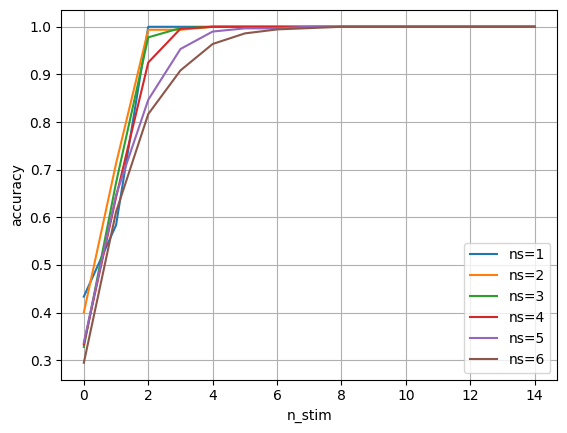

In [26]:
# plot the learning curve
plt.plot(z[z['set_size'] == 1]['corr'].values, label='ns=1')
plt.plot(z[z['set_size'] == 2]['corr'].values, label='ns=2')
plt.plot(z[z['set_size'] == 3]['corr'].values, label='ns=3')
plt.plot(z[z['set_size'] == 4]['corr'].values, label='ns=4')
plt.plot(z[z['set_size'] == 5]['corr'].values, label='ns=5')
plt.plot(z[z['set_size'] == 6]['corr'].values, label='ns=6')

plt.xlabel('n_stim')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.show()

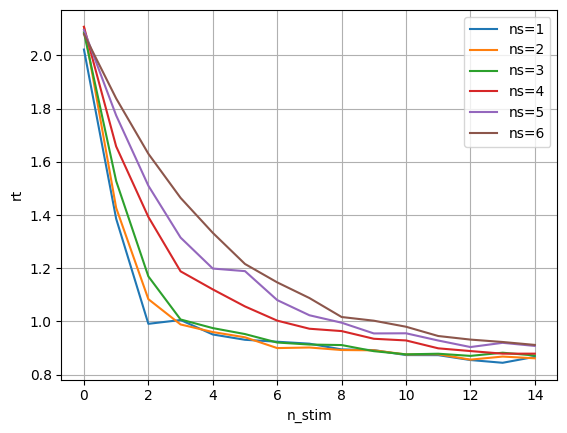

In [27]:
# plot the learning curve
plt.plot(z[z['set_size'] == 1]['rt'].values, label='ns=1')
plt.plot(z[z['set_size'] == 2]['rt'].values, label='ns=2')
plt.plot(z[z['set_size'] == 3]['rt'].values, label='ns=3')
plt.plot(z[z['set_size'] == 4]['rt'].values, label='ns=4')
plt.plot(z[z['set_size'] == 5]['rt'].values, label='ns=5')
plt.plot(z[z['set_size'] == 6]['rt'].values, label='ns=6')

plt.xlabel('n_stim')
plt.ylabel('rt')
plt.grid()
plt.legend()
plt.show()

## PyMC

###Prepare data for PyTensor

Rename data and make sure it is fully organized. Take a subsample of the data as necessary

In [28]:
df = PR_data.sort_values(['subj_idx', 'block_num'])
df = df.loc[df['subj_idx'].isin([0])]
# df = df.loc[df['block_num'].isin([0.0])]

This block onehots and pads the data so that it fits into the pytensor tensor5 shape which we can batch iterate over

In [29]:
# Collect necessary metadata from the dataframe
max_trials = df[['subj_idx','block_num']].value_counts().max()
max_stimuli = int(df['stim'].max()) + 1
n_participants = len(df['subj_idx'].unique())
n_choices = int(df['response'].max()) + 1
n_blocks = len(df['block_num'].unique())

# create the arrays which we will fill
shape = (n_participants, n_blocks, max_trials, n_choices, max_stimuli)
pad_value = 0
stim_choices = np.ones(shape) * pad_value
rewards = np.ones(shape) * pad_value
rts = np.ones(shape) * pad_value
set_sizes = np.repeat(np.array(df.groupby(['subj_idx','block_num']).mean()['set_size']),repeats=max_trials*n_choices*max_stimuli).flatten()
subj_idxs = np.repeat(np.arange(n_participants),max_trials*n_choices*n_blocks*max_stimuli).flatten()
block_nums = np.tile(np.repeat(np.arange(n_blocks), repeats=max_trials*n_choices*max_stimuli),n_participants).flatten()

# iterate over subject and block
for i, subj_idx in enumerate(df['subj_idx'].unique()):
    for j, block_num in enumerate(df['block_num'].unique()):

        # get subject block trial data
        subj_block_data = df[(df['subj_idx'] == subj_idx) & (df['block_num'] == block_num)]

        # pandas to numpy
        subj_block_stimuli = subj_block_data['stim'].to_numpy(dtype=np.int32)
        subj_block_choices = subj_block_data['response'].to_numpy(dtype=np.int32)
        subj_block_rewards = subj_block_data['feedback'].to_numpy(dtype=np.float32)
        subj_block_rts = subj_block_data['rt'].to_numpy(dtype=np.float32)

        # collect metadata relevant to this block
        n_trials = subj_block_data.shape[0]
        n_stimuli = subj_block_stimuli.max() + 1

        # onehotting data needed for state-action Q-Values - stimuli = state ; choice = action
        subj_stimuli_stim_choices = np.stack([subj_block_stimuli, subj_block_choices], axis=-1)
        onehot_stim_choices = np.zeros((n_trials, n_choices, n_stimuli))
        for t in range(n_trials):
            stim = subj_block_stimuli[t]
            choice = subj_block_choices[t]
            onehot_stim_choices[t,choice,stim] = 1

        # reshaping rewards and rts
        subj_block_rewards = subj_block_rewards.reshape((n_trials, 1, 1)).repeat(n_choices, axis=1).repeat(n_stimuli, axis=2)
        subj_block_rts = subj_block_rts.reshape((n_trials, 1, 1)).repeat(n_choices, axis=1).repeat(n_stimuli, axis=2)

        # slotting data into the final data structure format
        stim_choices[i, j, :n_trials, :, :n_stimuli] = onehot_stim_choices
        rewards[i, j, :n_trials, :, :n_stimuli] = subj_block_rewards
        rts[i, j, :n_trials, :, :n_stimuli] = subj_block_rts


# create a new dataframe by flatting all the data structure
# this data is now onehotted over stimuli and choices (states and actions) and padded over dummy trials (needed so that the dataframe takes the right shape when we reshape for batching)
padded_ohe_df = pd.DataFrame(data={'subj_idx': subj_idxs,
                               'block_num': block_nums,
                               'response': stim_choices.flatten(),
                               'feedback': rewards.flatten(),
                               'rt': rts.flatten(),
                               'set_size': set_sizes,
                               })
padded_ohe_df.shape

(35640, 6)

###PyMC Wrapper and Compile

In [30]:
# Copy & Pasted from previous cell for clarity
# These are used inside the wrapper function
max_trials = df[['subj_idx','block_num']].value_counts().max()
max_stimuli = int(df['stim'].max()) + 1
n_participants = len(df['subj_idx'].unique())
n_choices = int(df['response'].max()) + 1
n_blocks = len(df['block_num'].unique())

def rlwmssm_hdll(pA_, pB_, pC_, pE_, pG_, pP_, pR_, choices, rewards, set_sizes_, pssmA_, pssmZ_, pssmT_, df_rts_, df_choices_, weights_0__,weights_1__,weights_2__,weights_3__,biases_0__,biases_1__,biases_2__,biases_3__):
    """
    rlwmsmm_hdll: Wrapper function for hierarchical differentiable loglikelihood for RLWM-SSM

    dC: Choices (data)
    dq_RL: Precomputed RL Qs (empty)
    dq_WM: Precomputed WM Qs (empty)
    pB: Betas (parameter)
    pC: Working Memory Capacities (parameter)
    pE: Epsilons (parameter)
    pR: Rhos (parameter)
    set_sizes: set sizes for each participant block (data)
    pssmA: SSM As (parameter)
    pssmZ: SSM Zs (parameter)
    pssmT: SSM Thetas (parameter)
    dssmRT: SSM RTs (data)
    dssmC: unpadded Choices from SSM (data)
    weights_0: first layer weights (data)
    weights_1: second layer weights (data)
    weights_2: third layer weights (data)
    weights_3: fourth layer weights (data)
    biases_0: first layer biases (data)
    biases_1: second layer biases (data)
    biases_2: third layer biases (data)
    biases_3: fourth layer biases (data)
    """
    inner_shape = (n_participants, n_choices, n_blocks, max_stimuli)
    full_shape = (inner_shape[0], inner_shape[2], max_trials, inner_shape[1], inner_shape[3])
    dq_RL_ = pt.ones(inner_shape) / n_choices
    dq_WM_ = pt.ones(inner_shape) / n_choices

    dC_ = choices.reshape(full_shape).dimshuffle((2,0,3,1,4))
    dR_ = rewards.reshape(full_shape).dimshuffle((2,0,3,1,4))
    set_sizes_ = set_sizes_.reshape(full_shape).dimshuffle((2,0,3,1,4))

    pA_ = pA_.reshape(full_shape).dimshuffle((2,0,3,1,4))
    pB_ = pB_.reshape(full_shape).dimshuffle((2,0,3,1,4))
    pC_ = pC_.reshape(full_shape).dimshuffle((2,0,3,1,4))
    pE_ = pE_.reshape(full_shape).dimshuffle((2,0,3,1,4))
    pG_ = pG_.reshape(full_shape).dimshuffle((2,0,3,1,4))
    pP_ = pP_.reshape(full_shape).dimshuffle((2,0,3,1,4))
    pR_ = pR_.reshape(full_shape).dimshuffle((2,0,3,1,4))

    pssmA_ = pt.repeat(pssmA_, n_blocks * max_trials)
    pssmZ_ = pt.repeat(pssmZ_, n_blocks * max_trials)
    pssmT_ = pt.repeat(pssmT_, n_blocks * max_trials)

    return rlwmssm_recovery(dq_RL_, dq_WM_, dC_, dR_, pA_, pB_, pC_, pE_, pG_, pP_, pR_, set_sizes_, pssmA_, pssmZ_, pssmT_, df_rts_, df_choices_, weights_0__,weights_1__,weights_2__,weights_3__,biases_0__,biases_1__,biases_2__,biases_3__).flatten()

# PyTensor variables for compilation
pA = pt.dvector()
pB = pt.dvector()
pC = pt.dvector()
pE = pt.dvector()
pG = pt.dvector()
pP = pt.dvector()
pR = pt.dvector()
choices__ = pt.dvector()
rewards__ = pt.dvector()
set_sizes__ = pt.dvector()
df_rts__ = pt.dvector()
df_choices__ = pt.dvector()
pssmA__ = pt.dvector()
pssmZ__ = pt.dvector()
pssmT__ = pt.dvector()
weights_0__ = pt.dmatrix()
weights_1__ = pt.dmatrix()
weights_2__ = pt.dmatrix()
weights_3__ = pt.dmatrix()
biases_0__ = pt.dvector()
biases_1__ = pt.dvector()
biases_2__ = pt.dvector()
biases_3__ = pt.dvector()

# Compiling wrapper function (for testing)
output = rlwmssm_hdll(pA, pB, pC, pE, pG, pP, pR, choices__, rewards__, set_sizes__, pssmA__, pssmZ__, pssmT__, df_rts__, df_choices__, weights_0__,weights_1__,weights_2__,weights_3__,biases_0__,biases_1__,biases_2__,biases_3__)
my_rlwmssm_hdll_func = pytensor.function(inputs=[pA, pB, pC, pE, pG, pP, pR, choices__, rewards__, set_sizes__, pssmA__, pssmZ__, pssmT__, df_rts__, df_choices__, weights_0__,weights_1__,weights_2__,weights_3__,biases_0__,biases_1__,biases_2__, biases_3__], outputs=output, on_unused_input='ignore')

Here we define all the data we will need

In [31]:
pA_ = np.ones(padded_ohe_df.shape[0]).flatten() * rl_alpha[0]
pB_ = np.ones(padded_ohe_df.shape[0]).flatten() * 100
pC_ = np.ones(padded_ohe_df.shape[0]).flatten() * rl_C[0]
pE_ = np.ones(padded_ohe_df.shape[0]).flatten() * rl_epsilon[0]
pG_ = np.ones(padded_ohe_df.shape[0]).flatten() * rl_gamma[0]
pP_ = np.ones(padded_ohe_df.shape[0]).flatten() * rl_phi[0]
pR_ = np.ones(padded_ohe_df.shape[0]).flatten() * rl_rho[0]
# Uncommented is for non-trial-wise
# Commented is for trial-wise
pssmA_ = np.ones((n_participants,)) * rl_a[0] # np.ones((padded_ohe_df.shape[0]//n_choices)//max_stimuli).flatten() * rl_a[0]
pssmZ_ = np.ones((n_participants,)) * rl_z[0] # np.ones((padded_ohe_df.shape[0]//n_choices)//max_stimuli).flatten() * rl_z[0]
pssmT_ = np.ones((n_participants,)) * rl_theta[0] # np.ones((padded_ohe_df.shape[0]//n_choices)//max_stimuli).flatten() * rl_theta[0]
choices_ = padded_ohe_df['response'].to_numpy(dtype=np.int32)
rewards_ = padded_ohe_df['feedback'].to_numpy(dtype=np.float32)
set_sizes_ = padded_ohe_df['set_size'].to_numpy(dtype=np.float32)
df_choices_ = np.max(np.argmax(padded_ohe_df['response'].to_numpy(dtype=np.int32).reshape((-1,n_choices,max_stimuli)),axis=1),axis=1)
df_rts_ = np.max(np.max(padded_ohe_df['rt'].to_numpy(dtype=np.float32).reshape((-1,n_choices,max_stimuli)),axis=1),axis=1)
weights_0_ = weights_0
weights_1_ = weights_1
weights_2_ = weights_2
weights_3_ = weights_3
biases_0_ = biases_0
biases_1_ = biases_1
biases_2_ = biases_2
biases_3_ = biases_3

###PyTensor Python Comparison

In [32]:
# helper function for LL
def call_LAN(LAN_matrix):
    net_input = np.array(LAN_matrix).astype(np.float32)
    LL = torch_mlp.predict_on_batch(net_input)
    return np.sum(LL)

# Python LL - to be compared against the PyTensor LL
def RLWM_LL(params, subj_data, model_ssm, num_actions, beta):

    a = params[0]
    z = params[1]
    theta = params[2]

    alpha = params[3]
    phi = params[4]
    rho = params[5]
    gamma = params[6]
    epsilon = params[7]
    C = params[8]

    if a < 0.1 or a > 1.0:
        return np.inf

    if z < 0 or z >= a or z > 0.45:
        return np.inf

    if theta < 0 or theta > 1.2:
        return np.inf

    if alpha < 0 or alpha > 0.1: # CHECK
        return np.inf

    if phi < 0 or phi > 1.0: # CHECK
        return np.inf

    if rho < 0.0 or rho > 1: # CHECK
        return np.inf

    if gamma < 0.0 or gamma > 1.0:
        return np.inf

    if epsilon < 0 or epsilon > 0.1: # CHECK
        return np.inf

    if C < 2 or C > 5:
        return np.inf

    actions = np.arange(num_actions)
    pol = np.zeros(num_actions)

    block_list = np.unique(subj_data['block_num'])

    LAN_matrix = np.zeros((len(subj_data['rt']), len(ssms.config.model_config[model_ssm]['params']) + 2))
    subj_trl_idx = 0

    for bl in block_list:
        #print(">> block -- ", bl, len(np.unique(subj_data.loc[subj_data['block_num'] == bl]['stim'])))

        block_data = subj_data.loc[subj_data['block_num'] == bl]

        set_size = len(np.unique(block_data['stim']))

        trials = block_data['stim'].values
        reward_list = block_data['feedback'].values
        action_list = block_data['response'].values
        rt_list = block_data['rt'].values

        q_RL = np.ones((set_size, num_actions)) * 1/num_actions
        q_WM = np.ones((set_size, num_actions)) * 1/num_actions
        weight = rho * min(1, C/set_size)

        for tr in np.arange(len(trials)):
            state = int(trials[tr])

            pol_RL = softmax(q_RL[state, :], beta)
            pol_WM = softmax(q_WM[state, :], beta)

            pol = weight * pol_WM + (1-weight) * pol_RL

            pol_final = (1 - epsilon) * pol + epsilon * np.tile([1/num_actions], num_actions)

            #print(">> ", np.sum(pol_RL), np.sum(pol_WM), np.sum(pol), np.sum(pol_final), pol, pol_final)

            action = int(action_list[tr])
            reward = reward_list[tr]

            if (reward - q_RL[state, action]) >= 0:
                q_RL[state, action] = q_RL[state, action] + alpha * (reward - q_RL[state, action])
                q_WM[state, action] = q_WM[state, action] + 1 * (reward - q_WM[state, action])
            else:
                q_RL[state, action] = q_RL[state, action] + gamma * alpha * (reward - q_RL[state, action])
                q_WM[state, action] = q_WM[state, action] + gamma * 1 * (reward - q_WM[state, action])

            q_WM = q_WM + phi * ((1/num_actions)-q_WM)

            LAN_matrix[subj_trl_idx, :] = np.array([pol_final[0], pol_final[1], pol_final[2], a, z, theta, rt_list[tr], action])
            subj_trl_idx += 1
    #print(LAN_matrix)
    subj_ll = call_LAN(LAN_matrix) # Call LAN here

    return subj_ll

The next two cells run the PyTensor and Python likelihoods so that we can compare their outputs - if they differ there is an issue with the PyTensor version

In [33]:
my_rlwmssm_hdll_func(pA_, pB_, pC_, pE_, pG_, pP_, pR_, choices_, rewards_, set_sizes_, pssmA_, pssmZ_, pssmT_, df_rts_, df_choices_, weights_0_,weights_1_,weights_2_,weights_3_,biases_0_,biases_1_,biases_2_,biases_3_).sum()

400.8707716719554

In [34]:
ll = 0
for subj_idx in df['subj_idx'].unique():
  ll += RLWM_LL((pssmA_[0],pssmZ_[0],pssmT_[0], pA_[0], pP_[0], pR_[0], pG_[0], pE_[0], pC_[0]), df.loc[df['subj_idx']==subj_idx], ssms_model, n_choices, pB_[0])
ll

400.8710021972656

####Plot Comparisons

Comparing alphas

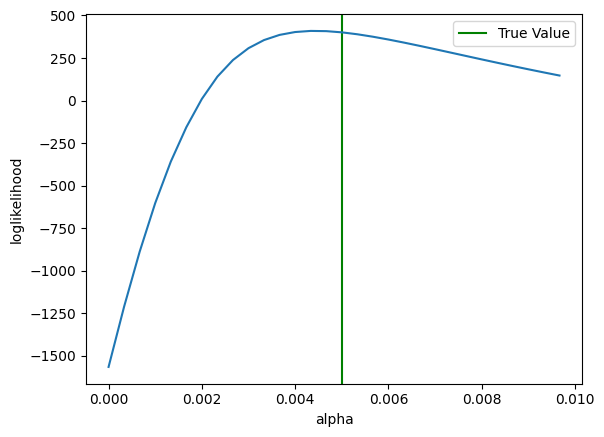

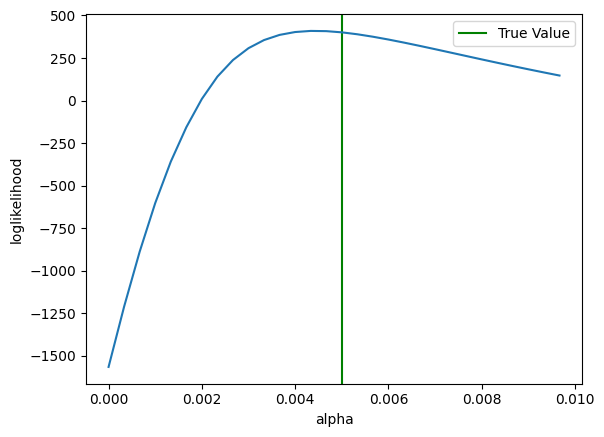

In [35]:
n_steps = 30
lower = 0
upper = 0.01
steps = np.arange(lower,upper,(upper-lower)/n_steps)
pytensor_ll = np.zeros((n_steps,))
python_ll = np.zeros((n_steps,))
pA_temp = np.ones(padded_ohe_df.shape[0]).flatten() * 1.0
for i, step in enumerate(steps):
    for subj_idx in df['subj_idx'].unique():
        python_ll[i] += RLWM_LL((pssmA_[0],pssmZ_[0],pssmT_[0], pA_temp[0]*step, pP_[0], pR_[0], pG_[0], pE_[0], pC_[0]), df.loc[df['subj_idx']==subj_idx], ssms_model, n_choices, pB_[0])
    pytensor_ll[i] = my_rlwmssm_hdll_func(pA_temp*step, pB_, pC_, pE_, pG_, pP_, pR_, choices_, rewards_, set_sizes_, pssmA_, pssmZ_, pssmT_, df_rts_, df_choices_, weights_0_,weights_1_,weights_2_,weights_3_,biases_0_,biases_1_,biases_2_,biases_3_).sum()

plt.xlabel('alpha')
plt.ylabel('loglikelihood')
plt.axvline(x=0.005, color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,pytensor_ll)
plt.show()
plt.xlabel('alpha')
plt.ylabel('loglikelihood')
plt.axvline(x=0.005, color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,python_ll)

Comparing Cs

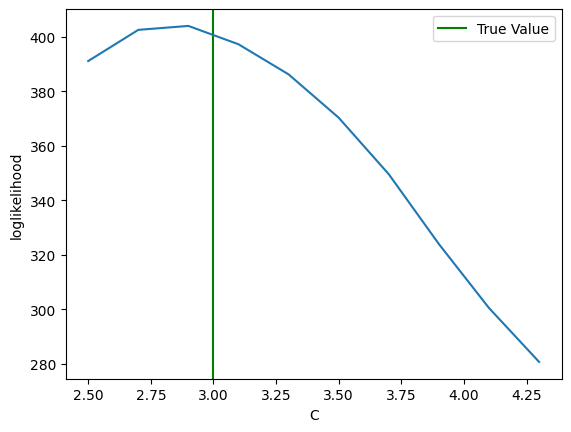

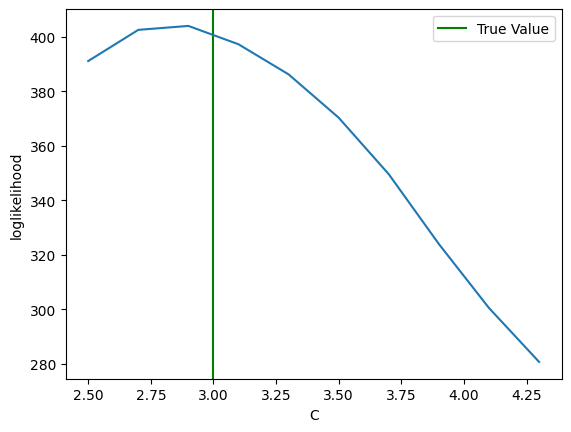

In [36]:
n_steps = 10
lower = 2.5
upper = 4.5
steps = np.arange(lower,upper,(upper-lower)/n_steps)
pytensor_ll = np.zeros((n_steps,))
python_ll = np.zeros((n_steps,))
pC_temp = np.ones(padded_ohe_df.shape[0]).flatten() * 1.0
for i, step in enumerate(steps):
    for subj_idx in df['subj_idx'].unique():
        python_ll[i] += RLWM_LL((pssmA_[0],pssmZ_[0],pssmT_[0], pA_[0], pP_[0], pR_[0], pG_[0], pE_[0], pC_temp[0]*step), df.loc[df['subj_idx']==subj_idx], ssms_model, n_choices, pB_[0])
    pytensor_ll[i] = my_rlwmssm_hdll_func(pA_, pB_, pC_temp*step, pE_, pG_, pP_, pR_, choices_, rewards_, set_sizes_, pssmA_, pssmZ_, pssmT_, df_rts_, df_choices_, weights_0_,weights_1_,weights_2_,weights_3_,biases_0_,biases_1_,biases_2_,biases_3_).sum()

plt.xlabel('C')
plt.ylabel('loglikelihood')
plt.axvline(x=pC_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,pytensor_ll)
plt.show()
plt.xlabel('C')
plt.ylabel('loglikelihood')
plt.axvline(x=pC_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,python_ll)

Comparing epsilons

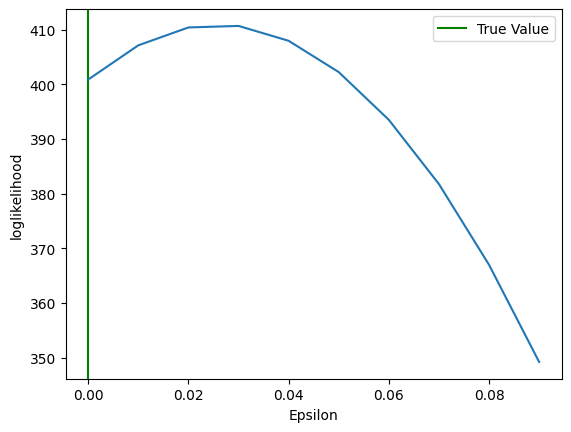

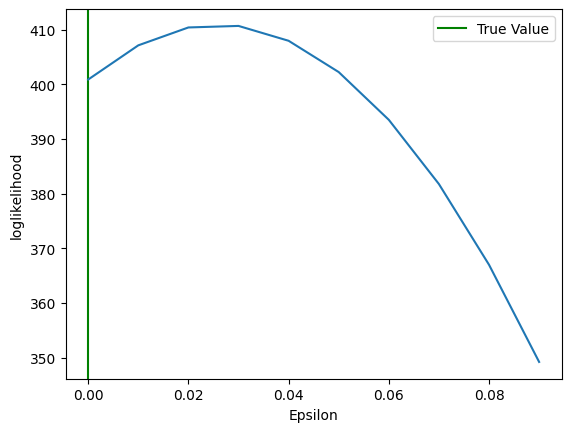

In [37]:
n_steps = 10
lower = 0
upper = 0.1
steps = np.arange(lower,upper,(upper-lower)/n_steps)
pytensor_ll = np.zeros((n_steps,))
python_ll = np.zeros((n_steps,))
pE_temp = np.ones(padded_ohe_df.shape[0]).flatten() * 1.0
for i, step in enumerate(steps):
    for subj_idx in df['subj_idx'].unique():
        python_ll[i] += RLWM_LL((pssmA_[0],pssmZ_[0],pssmT_[0], pA_[0], pP_[0], pR_[0], pG_[0], pE_temp[0]*step, pC_[0]), df.loc[df['subj_idx']==subj_idx], ssms_model, n_choices, pB_[0])
    pytensor_ll[i] = my_rlwmssm_hdll_func(pA_, pB_, pC_, pE_temp*step, pG_, pP_, pR_, choices_, rewards_, set_sizes_, pssmA_, pssmZ_, pssmT_, df_rts_, df_choices_, weights_0_,weights_1_,weights_2_,weights_3_,biases_0_,biases_1_,biases_2_,biases_3_).sum()

plt.xlabel('Epsilon')
plt.ylabel('loglikelihood')
plt.axvline(x=pE_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,pytensor_ll)
plt.show()
plt.xlabel('Epsilon')
plt.ylabel('loglikelihood')
plt.axvline(x=pE_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,python_ll)

Comparing gammas

In [ ]:
n_steps = 10
lower = 0
upper = 1.0
steps = np.arange(lower,upper,(upper-lower)/n_steps)
pytensor_ll = np.zeros((n_steps,))
python_ll = np.zeros((n_steps,))
pG_temp = np.ones(padded_ohe_df.shape[0]).flatten() * 1.0
for i, step in enumerate(steps):
    for subj_idx in df['subj_idx'].unique():
        python_ll[i] += RLWM_LL((pssmA_[0],pssmZ_[0],pssmT_[0], pA_[0], pP_[0], pR_[0], pG_temp[0]*step, pE_[0], pC_[0]), df.loc[df['subj_idx']==subj_idx], ssms_model, n_choices, pB_[0])
    pytensor_ll[i] = my_rlwmssm_hdll_func(pA_, pB_, pC_, pE_, pG_temp*step, pP_, pR_, choices_, rewards_, set_sizes_, pssmA_, pssmZ_, pssmT_, df_rts_, df_choices_, weights_0_,weights_1_,weights_2_,weights_3_,biases_0_,biases_1_,biases_2_,biases_3_).sum()

plt.xlabel('Gamma')
plt.ylabel('loglikelihood')
plt.axvline(x=pG_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,pytensor_ll)
plt.show()
plt.xlabel('Gamma')
plt.ylabel('loglikelihood')
plt.axvline(x=pG_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,python_ll)

Comparing phis

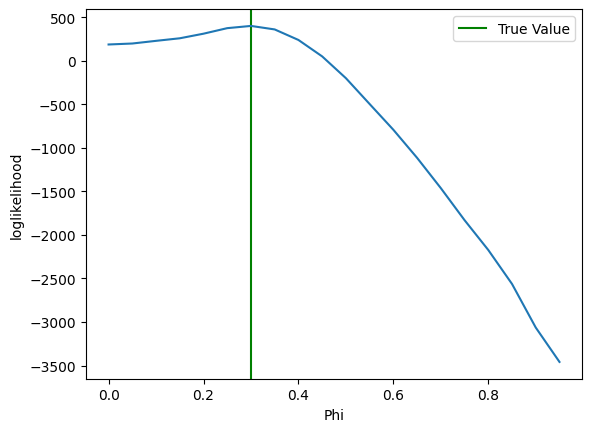

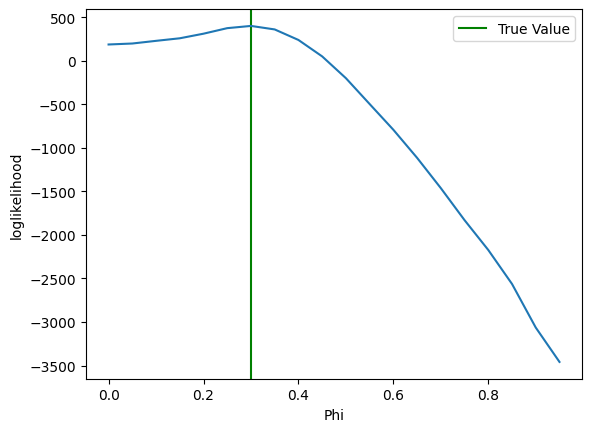

In [38]:
n_steps = 20
lower = 0
upper = 1.0
steps = np.arange(lower,upper,(upper-lower)/n_steps)
pytensor_ll = np.zeros((n_steps,))
python_ll = np.zeros((n_steps,))
pP_temp = np.ones(padded_ohe_df.shape[0]).flatten() * 1.0
for i, step in enumerate(steps):
    for subj_idx in df['subj_idx'].unique():
        python_ll[i] += RLWM_LL((pssmA_[0],pssmZ_[0],pssmT_[0], pA_[0], pP_temp[0]*step, pR_[0], pG_[0], pE_[0], pC_[0]), df.loc[df['subj_idx']==subj_idx], ssms_model, n_choices, pB_[0])
    pytensor_ll[i] = my_rlwmssm_hdll_func(pA_, pB_, pC_, pE_, pG_, pP_temp*step, pR_, choices_, rewards_, set_sizes_, pssmA_, pssmZ_, pssmT_, df_rts_, df_choices_, weights_0_,weights_1_,weights_2_,weights_3_,biases_0_,biases_1_,biases_2_,biases_3_).sum()

plt.xlabel('Phi')
plt.ylabel('loglikelihood')
plt.axvline(x=pP_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,pytensor_ll)
plt.show()
plt.xlabel('Phi')
plt.ylabel('loglikelihood')
plt.axvline(x=pP_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,python_ll)

Comparing rhos

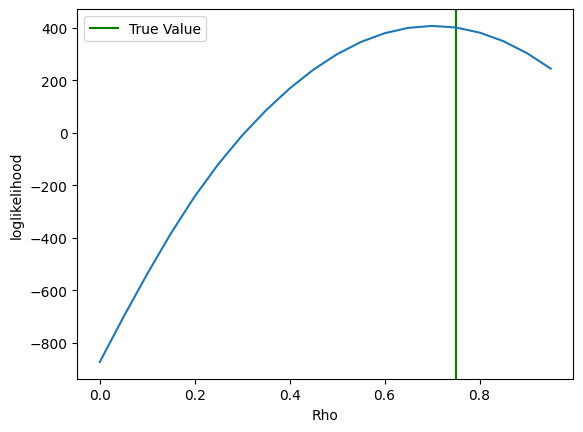

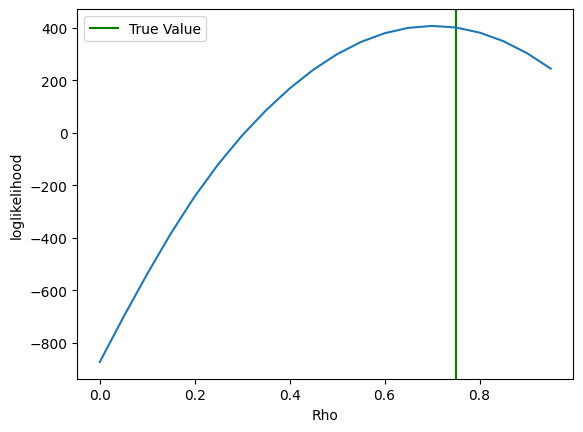

In [39]:
n_steps = 20
lower = 0
upper = 1.0
steps = np.arange(lower,upper,(upper-lower)/n_steps)
pytensor_ll = np.zeros((n_steps,))
python_ll = np.zeros((n_steps,))
pR_temp = np.ones(padded_ohe_df.shape[0]).flatten() * 1.0
for i, step in enumerate(steps):
    for subj_idx in df['subj_idx'].unique():
        python_ll[i] += RLWM_LL((pssmA_[0],pssmZ_[0],pssmT_[0], pA_[0], pP_[0], pR_temp[0]*step, pG_[0], pE_[0], pC_[0]), df.loc[df['subj_idx']==subj_idx], ssms_model, n_choices, pB_[0])
    pytensor_ll[i] = my_rlwmssm_hdll_func(pA_, pB_, pC_, pE_, pG_, pP_, pR_temp*step, choices_, rewards_, set_sizes_, pssmA_, pssmZ_, pssmT_, df_rts_, df_choices_, weights_0_,weights_1_,weights_2_,weights_3_,biases_0_,biases_1_,biases_2_,biases_3_).sum()

plt.xlabel('Rho')
plt.ylabel('loglikelihood')
plt.axvline(x=pR_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,pytensor_ll)
plt.show()
plt.xlabel('Rho')
plt.ylabel('loglikelihood')
plt.axvline(x=pR_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,python_ll)

####Likelihood Gridplots

Grid plot comparing Phi and Epsilon

Text(0.5, 0, 'Epsilon')

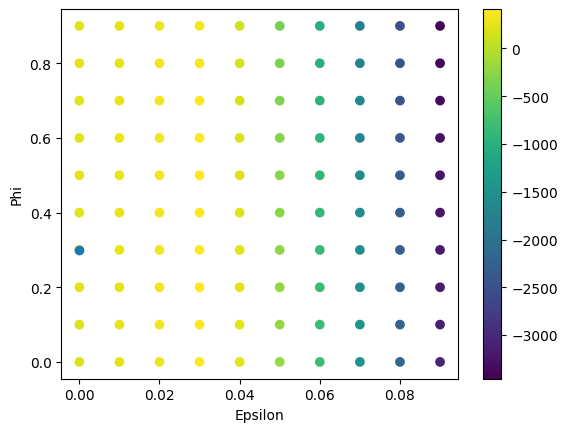

In [40]:
n_steps = 10
lower_i = 0
upper_i = 0.1
lower_j = 0
upper_j = 1.0
steps_i = np.arange(lower_i,upper_i,(upper_i-lower_i)/n_steps)
steps_j = np.arange(lower_j,upper_j,(upper_j-lower_j)/n_steps)
pytensor_ll = np.zeros((n_steps,n_steps))
python_ll = np.zeros((n_steps,n_steps))
pP_temp = np.ones(padded_ohe_df.shape[0]).flatten() * 1.0
pE_temp = np.ones(padded_ohe_df.shape[0]).flatten() * 1.0
coords = []
for j, step_j in enumerate(steps_j):
  for i, step_i in enumerate(steps_i):
      coords.append([step_i,step_j])
      pytensor_ll[i,j] = my_rlwmssm_hdll_func(pA_, pB_, pC_, pE_temp*step_i, pG_, pP_temp*step_j, pR_, choices_, rewards_, set_sizes_, pssmA_, pssmZ_, pssmT_, df_rts_, df_choices_, weights_0_,weights_1_,weights_2_,weights_3_,biases_0_,biases_1_,biases_2_,biases_3_).sum()
pytensor_ll = pytensor_ll.flatten()
coords = np.array(coords)
plt.scatter(coords[:,0], coords[:,1], c=pytensor_ll)
plt.colorbar()
plt.scatter(pE_[0],pP_[0])
plt.ylabel('Phi')
plt.xlabel('Epsilon')

Grid plot comparing C and Epsilon

Text(0.5, 0, 'Epsilon')

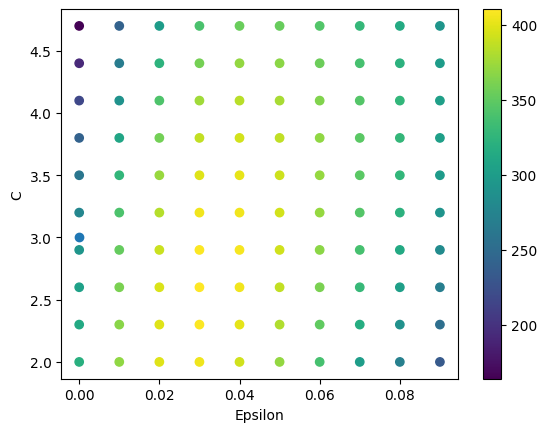

In [43]:
n_steps = 10
lower_i = 0
upper_i = 0.1
lower_j = 2
upper_j = 5
steps_i = np.arange(lower_i,upper_i,(upper_i-lower_i)/n_steps)
steps_j = np.arange(lower_j,upper_j,(upper_j-lower_j)/n_steps)
pytensor_ll = np.zeros((n_steps,n_steps))
python_ll = np.zeros((n_steps,n_steps))
pC_temp = np.ones(padded_ohe_df.shape[0]).flatten() * 1.0
pE_temp = np.ones(padded_ohe_df.shape[0]).flatten() * 1.0
coords = []
for j, step_j in enumerate(steps_j):
  for i, step_i in enumerate(steps_i):
      coords.append([step_i,step_j])
      pytensor_ll[i,j] = my_rlwmssm_hdll_func(pA_, pB_, pC_temp*step_j, pE_temp*step_i, pG_, pP_, pR_, choices_, rewards_, set_sizes_, pssmA_, pssmZ_, pssmT_, df_rts_, df_choices_, weights_0_,weights_1_,weights_2_,weights_3_,biases_0_,biases_1_,biases_2_,biases_3_).sum()
pytensor_ll = pytensor_ll.flatten()
coords = np.array(coords)
plt.scatter(coords[:,0], coords[:,1], c=pytensor_ll)
plt.colorbar()
plt.scatter(pE_[0],pC_[0])
plt.ylabel('C')
plt.xlabel('Epsilon')

###Run PyMC

In [29]:
# Make coordinates
participant_ids, participants = pd.factorize(padded_ohe_df['subj_idx'])
coords = {
          "participant_idx": np.array(participants),
          "obs_idx": np.arange(padded_ohe_df.shape[0])
         }

with pm.Model(coords=coords) as hierarchical_model:
    # Data
    #Choices = pm.ConstantData('Choices', padded_ohe_df['response'].to_numpy())
    #Rewards = pm.ConstantData('Rewards', padded_ohe_df['feedback'].to_numpy())
    #Set_sizes = pm.ConstantData('Set_sizes', padded_ohe_df['set_size'].to_numpy())
    Choices = pm.ConstantData('Choices', choices_)
    Rewards = pm.ConstantData('Rewards', rewards_)
    Set_sizes = pm.ConstantData('Set_sizes', set_sizes_)
    DF_choices = pm.ConstantData('DF_choices', df_choices_)
    DF_rts = pm.ConstantData('DF_rts', df_rts_)

    Weights_0 = pm.ConstantData('Weights_0', weights_0_)
    Weights_1 = pm.ConstantData('Weights_1', weights_1_)
    Weights_2 = pm.ConstantData('Weights_2', weights_2_)
    Weights_3 = pm.ConstantData('Weights_3', weights_3_)
    Biases_0 = pm.ConstantData('Biases_0', biases_0_)
    Biases_1 = pm.ConstantData('Biases_1', biases_1_)
    Biases_2 = pm.ConstantData('Biases_2', biases_2_)
    Biases_3 = pm.ConstantData('Biases_3', biases_3_)

    # Priors for variables
    # pA = pm.ConstantData('pA', np.ones_like(choices_) * rl_alpha[0])
    pB = pm.ConstantData('pB', np.ones_like(choices_) * 100.0)
    # pC = pm.ConstantData('pC', np.ones_like(choices_) * rl_C[0])
    # pE = pm.ConstantData('pE', np.ones_like(choices_) * rl_epsilon[0])
    # pG = pm.ConstantData('pG', np.ones_like(choices) * rl_gamma[0])
    # pP = pm.ConstantData('pP', np.ones_like(choices_) * rl_phi[0])
    # pR = pm.ConstantData('pR', np.ones_like(choices_) * rl_rho[0])
    # pssmA = pm.ConstantData('pssmA', pssmA_)#  * rl_a[0]
    # pssmZ = pm.ConstantData('pssmZ', pssmZ_)#  * rl_z[0]
    # pssmT = pm.ConstantData('pssmT', pssmT_)#  * rl_theta[0]
    pA = pm.TruncatedNormal(name="pA", mu=0.005, sigma=0.01, lower=0.001, upper=0.1, dims="participant_idx", initval=np.array(pA_[0]).reshape((-1,)))
    # pA = pm.Beta(name='pA', alpha=2.0, beta=100, dims="participant_idx")#, initval=np.array(pA_[0]).reshape((-1,)))
    # pA = pm.Exponential(name='pA', lam=15, dims='participant_idx')
    # pB = pm.Uniform(name="pB", lower=0.8, upper=1.2, dims="participant_idx")
    pC = pm.TruncatedNormal(name="pC", mu=3.0, sigma=0.25, lower=2, upper=5, dims="participant_idx", initval=np.array(pC_[0]).reshape((-1,)))#, initval=np.array(pC_[0]).reshape((-1,)))
    pE = pm.TruncatedNormal(name="pE", mu=0.00, sigma=0.01, lower=0.0, upper=0.05, dims="participant_idx")
    pG = pm.TruncatedNormal(name="pG", mu=0.2, sigma=0.1, lower=0.0, upper=0.3, dims="participant_idx", initval=np.array(pG_[0]).reshape((-1,)))#, initval=np.array(pG_[0]).reshape((-1,)))
    pP = pm.TruncatedNormal(name="pP",  mu=0.3, sigma=0.25, lower=0.0, upper=1.0, dims="participant_idx", initval=np.array(pP_[0]).reshape((-1,)))#, initval=np.array(pP_[0]).reshape((-1,)))
    pR = pm.TruncatedNormal(name="pR",  mu=0.8, sigma=0.25, lower=0.0, upper=1.0, dims="participant_idx", initval=np.array(pR_[0]).reshape((-1,)))#, initval=np.array(pR_[0]).reshape((-1,)))
    pssmA = pm.TruncatedNormal(name="pssmA", mu=0.9, sigma=0.1, lower=0.1, upper=1.0, dims="participant_idx", initval=np.array(pssmA_[0]).reshape((-1,)))
    pssmZ = pm.TruncatedNormal(name="pssmZ", mu=0.1, sigma=0.1, lower=0.0, upper=0.45, dims="participant_idx", initval=np.array(pssmZ_[0]).reshape((-1,)))
    pssmT = pm.TruncatedNormal(name="pssmT", mu=0.05, sigma=0.1, lower=0.01, upper=0.2, dims="participant_idx", initval=np.array(pssmT_[0]).reshape((-1,)))


    # Render parameters trial wise
    pA_trial = pA[participant_ids]
    # pB_trial = pB[participant_ids]
    pC_trial = pC[participant_ids]
    pE_trial = pE[participant_ids]
    pG_trial = pG[participant_ids]
    pP_trial = pP[participant_ids]
    pR_trial = pR[participant_ids]
    # pA_trial = pA
    pB_trial = pB
    # pC_trial = pC
    # pE_trial = pE
    # pG_trial = pG
    #pP_trial = pP
    #pR_trial = pR
    pssmA_trial = pssmA
    pssmZ_trial = pssmZ
    pssmT_trial = pssmT

    # CHOOSE WHICH WRAPPER FUNCTION TO USE HERE
    pm.Potential("log_likelihood",
                 rlwmssm_hdll(pA_trial, pB_trial, pC_trial, pE_trial, pG_trial, pP_trial, pR_trial, Choices, Rewards, Set_sizes,
                              pssmA_trial, pssmZ_trial, pssmT_trial, DF_rts, DF_choices,
                              Weights_0,Weights_1,Weights_2,Weights_3,Biases_0,Biases_1,Biases_2,Biases_3))
    idata_pooled = pm.sample(50, tune=50, chains=1, nuts_sampler="numpyro")

sample: 100%|██████████| 100/100 [00:12<00:00,  8.31it/s, 1 steps of size 2.91e-40. acc. prob=0.00]


/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Y

array([[<Axes: title={'center': 'pA'}>, <Axes: title={'center': 'pA'}>],
       [<Axes: title={'center': 'pC'}>, <Axes: title={'center': 'pC'}>],
       [<Axes: title={'center': 'pE'}>, <Axes: title={'center': 'pE'}>],
       [<Axes: title={'center': 'pG'}>, <Axes: title={'center': 'pG'}>],
       [<Axes: title={'center': 'pP'}>, <Axes: title={'center': 'pP'}>],
       [<Axes: title={'center': 'pR'}>, <Axes: title={'center': 'pR'}>],
       [<Axes: title={'center': 'pssmA'}>,
        <Axes: title={'center': 'pssmA'}>],
       [<Axes: title={'center': 'pssmZ'}>,
        <Axes: title={'center': 'pssmZ'}>],
       [<Axes: title={'center': 'pssmT'}>,
        <Axes: title={'center': 'pssmT'}>]], dtype=object)

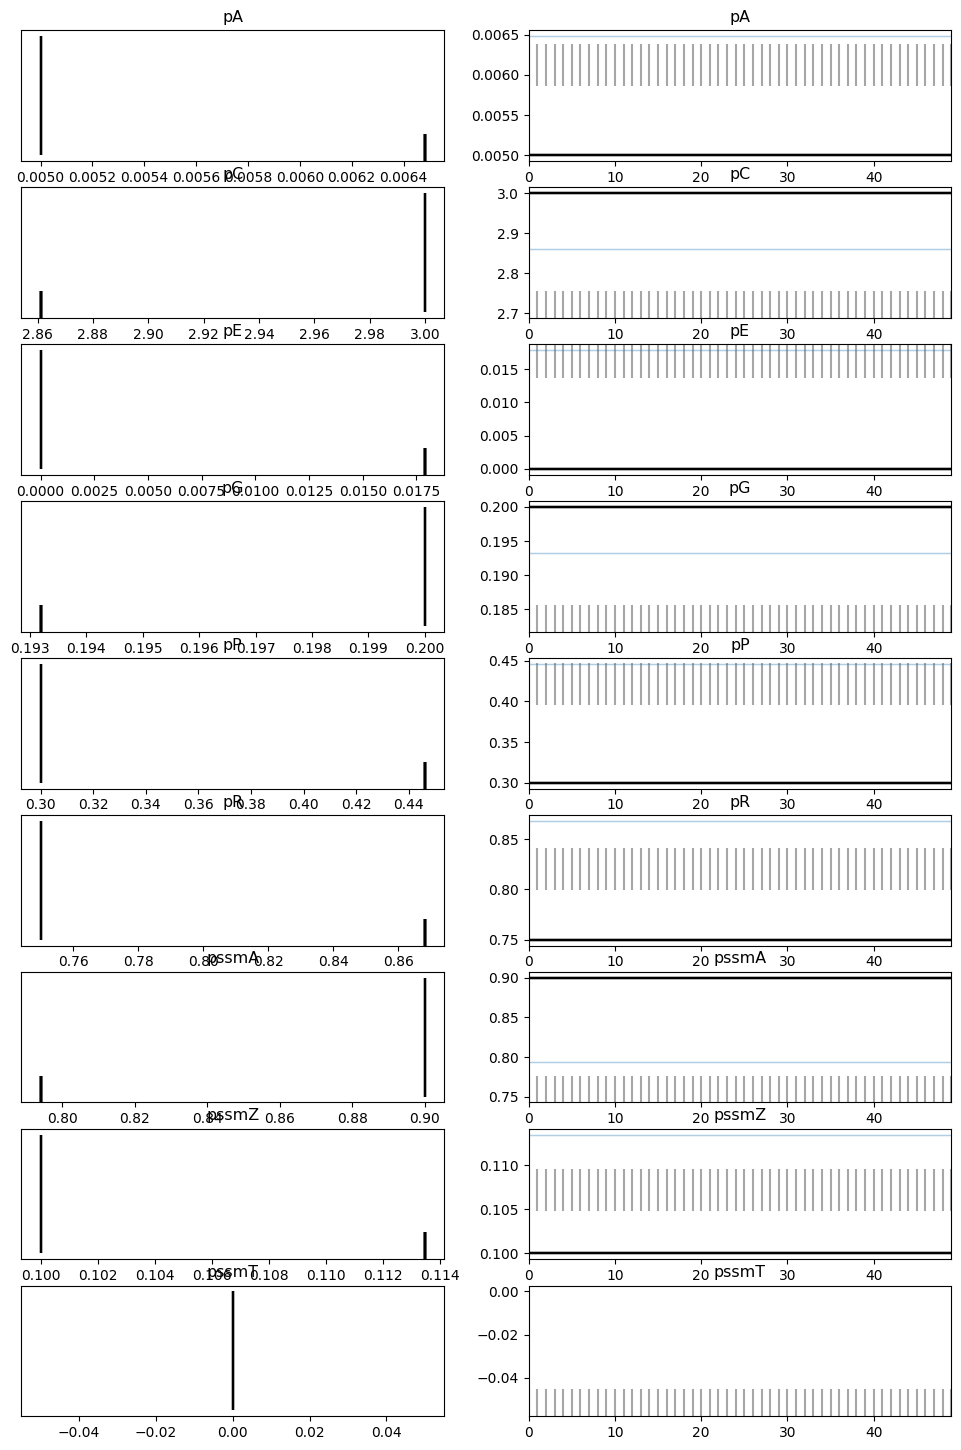

In [30]:
az.plot_trace(idata_pooled, lines=[
    ("pA", {}, rl_alpha),
    ("pC", {}, rl_C),
    ("pE", {}, rl_epsilon),
    ("pG", {}, rl_gamma),
    ("pP", {}, rl_phi),
    ("pR", {}, rl_rho),
    ("pssmA", {}, rl_a),
    ("pssmZ", {}, rl_z),
    ("pssmT", {}, rl_theta),
])

In [33]:
idata_pooled.sample_stats['diverging'].mean()

<xarray.DataArray 'diverging' ()>
array(0.)

array([[<Axes: ylabel='pC\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='pE\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='pG\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='pP\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='pR\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='pssmA\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='pA\n0', ylabel='pssmZ\n0'>,
        <Axes: xlabel='pC\n0'>, <Axes: xlabel='pE\n0'>,
        <Axes: xlabel='pG\n0'>, <Axes: xlabel='pP\n0'>,
        <Axes: xlabel='pR\n0'>, <Axes: xlabel='pssmA\n0'>]], dtype=object)

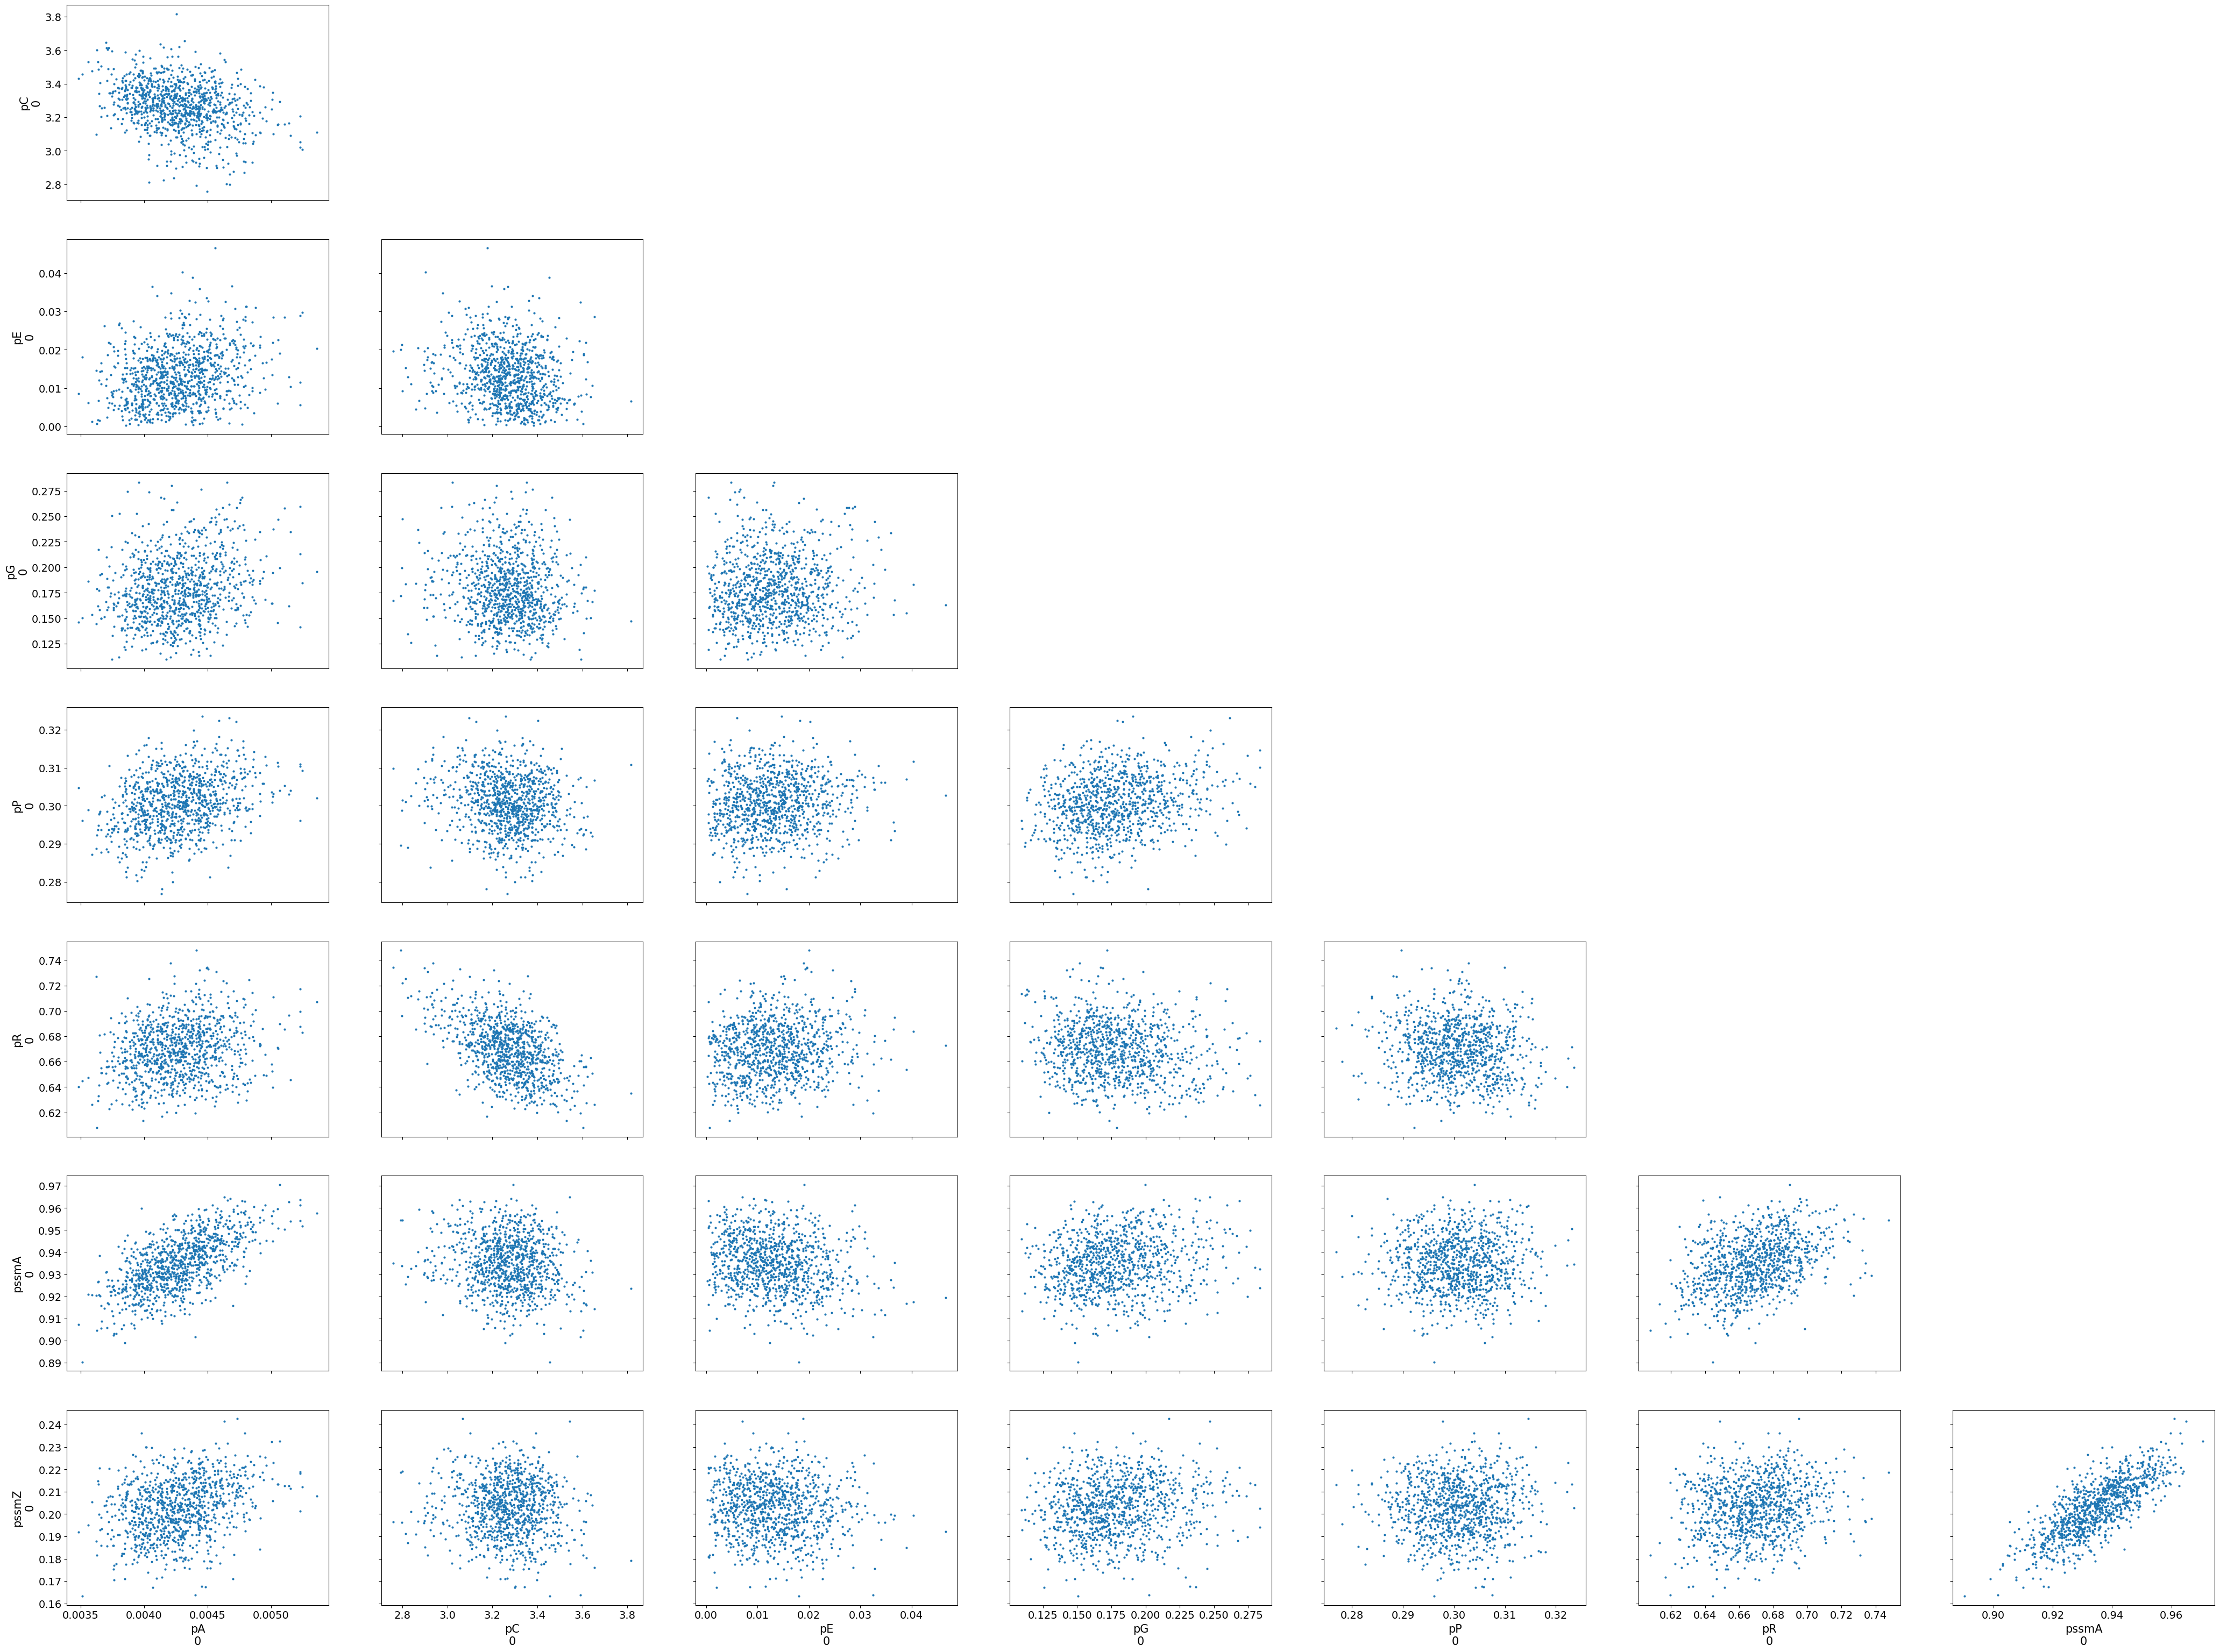

In [32]:
az.plot_pair(idata_pooled)